In [339]:
from glob import glob
import json
import os
import numpy as np
import pandas as pd
from plotnine import *

# Define amplicons

In [340]:
amplicons = ['RBD', 'NTD', 'S1S2']
amplicon_ranges = {'RBD': [22795, 23299], 'S1S2': [23222, 23740], 'NTD': [21730, 22220]}

primers = {'s1s2_F1': [22985, 23004],
's1s2_F2': [23202, 23221],
's1s2_R2': [23741, 23763],
's1s2_R1': [23892, 23913],
'ntd_F1': [21663, 21686],
'ntd_F2': [21707, 21729],
'ntd_R2': [22221, 22241],
'ntd_R1': [22322, 22341],
'rbd_F1': [22732, 22758],
'rbd_F2': [22773,22794],
'rbd_R2': [23300, 23322],
'rbd_R1': [23382,23403]}

# Load and process the GISAID mutation table from COVID-CG

In [341]:
s_gene_start = 21563
s_gene_stop = 25384

covid_cg_snvs1 = "/Users/rosekantor/data/wbe_scv/variant_info/consensus_mutations_covidcg_1perc_032822.json"
var1_df = pd.read_json(covid_cg_snvs1)
var1_df = var1_df.rename(columns={'pos':'position', 'name':'variant'})
var1_df = var1_df[(var1_df.position >= s_gene_start) & (var1_df.position <= s_gene_stop)]

# Process Sequencing data

## Define analysis and manipulation functions

In [436]:
# load nextclade output

def load_nextclade(results_file):
    nextclade_df = pd.read_csv(results_file, sep=';')
    nextclade_df = nextclade_df.replace(np.nan, '')
    nextclade_df[['seqName', 'clade', 'substitutions', 'deletions', 'insertions',
           'frameShifts', 'aaSubstitutions', 'aaDeletions', 'missing', 'nonACGTNs',
           'pcrPrimerChanges', 'alignmentScore', 'alignmentStart', 'alignmentEnd']]
    return nextclade_df


def make_abund_table(results_file, min_reads=1000, min_read_support=10, min_frac_abund=0.01):
    '''
    process the abundance table to trim and mask:
        drop samples with fewer than min_reads
        mask sequences with fewer than min_read_support reads in a given sample
        convert read counts to relative abundance within each sample
        drop sequences that are not above min_frac_abund in at least 1 sample
        drop all sequences that now sum to zero across all samples due to masking
        return pandas dataframe percent relative abundance table:
            columns are named as sequence IDs, ordered by average abundance
            rows are samples
    '''
    
    abund_raw_df = pd.read_csv(results_file, index_col=0) # the index_col=0 is necessary for the renamed files

    # generate seqnames for columns to match the names in the fasta used by nextclade
    seq_count = len(abund_raw_df.columns)
    seq_names = ['Seq'+str(x) for x in range(seq_count+1)][1:]
    abund_raw_df.columns = seq_names

    # drop samples (rows) with fewer than min_reads total
    abund_raw_df = abund_raw_df.drop(abund_raw_df.index[abund_raw_df.sum(axis=1) < min_reads])

    # if a seq has < min_read_support reads in a sample, change readcount to zero to avoid low-abundance artefacts
    abund_raw_df = abund_raw_df.mask(abund_raw_df < min_read_support, 0)

    # normalize to get relative abundance within samples
    abund_df = abund_raw_df.div(abund_raw_df.sum(axis=1), axis=0)

#     # if a seq is < min_perc_abund%, mask so we aren't considering rare variants since these will add noise
#     # this method will drop seqs from individual samples if below min_perc_abund in that sample
#     # but it seems better to keep these seqs as long as they are above min_perc_abund in at least 1 sample
#     abund_df = abund_df.mask(abund_df < min_frac_abund, 0)

    # if a seq has maximum abundance < min_perc_abund across all samples, drop it so we aren't considering rare variants since these will add noise
    abund_df = abund_df.replace(0, np.nan) # first replace 0 with nan so we can get minimum non-zero value below
    abund_df = abund_df.loc[:,(abund_df.max(axis=0) > min_frac_abund)]
#     # drop seqs that were only seen once -- NOTE: this drops dominant sequences sometimes; bad idea
#     abund_df = abund_df.loc[:,(abund_df.count(axis=0) > 1)]
    abund_df = abund_df.replace(np.nan, 0) # replace nans to zeros again

    # drop columns/amplicon sequences that sum to zero after all this masking
    abund_df = abund_df.drop(abund_df.columns[abund_df.sum(axis=0) == 0], axis=1)

    # round proportions so easier to look at and convert to percentages
    abund_df = abund_df * 100
    #abund_df = abund_df.round(3)

    # order the columns based on average abundance in a sample
    columns_ordered = abund_df.mean(axis=0).sort_values(ascending=False).index.to_list()
    abund_df = abund_df[columns_ordered]

    # sample names from batch 1 RBD have prefixes: 'RBD', 'rRd', 'STD'
    # STD and rRd are duplicates with different RNA prep steps, drop STD

    abund_df = abund_df[~abund_df.index.str.startswith('STD')]
    # extract sample names without prefixes, for samples that have them (all else will be NaN)
    abund_df['alt_name'] = abund_df.index.str.extract(r'.+_(.+_.+_.+_.+_.+)')[0].to_list()
    abund_df['Sample'] = abund_df.index
    abund_df.loc[~abund_df.alt_name.isna(), 'Sample'] = abund_df.alt_name
    abund_df = abund_df.set_index('Sample')
    abund_df = abund_df.drop(columns='alt_name')
    
    return abund_df


def add_sample_info(sites_df, abund_df):
    '''add sample name, metadata, and qPCR data
        input: abund_df - output from make_abund_table
                sites_df - qPCR data from wbe data analysis pipeline
    '''
    # extract the sample_code and date from the sample name
    abund_df = abund_df.reset_index()
    abund_df[['sample_code', 'date_string']] = abund_df.Sample.str.extract(r'(.+_.+_.+)_(\d{6})_.*')
    abund_df['date_sampling'] = pd.to_datetime(abund_df.date_string, format='%m%d%y')
    abund_df = abund_df.drop(columns = 'date_string')
    
    # merge site metadata with abundance table
    abund_named_df = sites_df.merge(abund_df, how='right', on='sample_code')#.reset_index(drop=True)
    
    return abund_named_df


def melt_abund_table(abund_df):
    abund_melt_df = abund_df.melt(id_vars=['Sample', 'county', 'site_full_name', 'date_sampling', 'sample_code'],
                                             var_name='Sequence',
                                             value_name='Abundance')

    return abund_melt_df

## Read and process all data combined

In [437]:
amplicons = ['RBD', 'NTD', 'S1S2']

# define data paths
results = '/Users/rosekantor/data/wbe_scv/results_sgene' # or change to directory with specific data to analyze
sites_df = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_sequencing.csv') # static

# make informative sample names
sites_df = sites_df[['sample_code', 'county', 'site_full_name']]
#sites_df['sample_name'] = sites_df[['county', 'site_full_name', 'date_sampling']].agg('_'.join, axis=1)

In [344]:
# # fix sample names in archive and re-save the results files with fixed names (one time)
# sample_df_archive_QB3 = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/sample_table_renamed.csv')
# sample_df_archive_UCD = pd.read_csv('/Users/rosekantor/data/wbe_scv/ucdavis_sgene_111422/sample_table_renamed.csv')
# samples_archive = pd.concat([sample_df_archive_UCD, sample_df_archive_QB3])
# samples_archive = samples_archive[['sample_id', 'merge_id']]
# samples_archive = samples_archive.drop_duplicates()

# for amplicon in ['RBD', 'NTD']:
#     results_df = pd.read_csv(f'{results}/{amplicon}_combined_dada2_out.csv')
#     results_df.insert(0, 'sample_id', results_df.index)
    
#     # fix messed up names (for aligning with location and plotting)
#     results_df.loc[results_df.sample_id=='D_OSP_031022_3', 'sample_id'] = 'D_OSP_INF_031022_3'
#     results_df.loc[results_df.sample_id=='D_OSP_031422_4', 'sample_id'] = 'D_OSP_INF_031422_4'

#     results_df = samples_archive.merge(results_df, how='right', on='sample_id')
#     results_df.loc[results_df.merge_id.isna(), 'merge_id'] = results_df.sample_id
#     results_df.index = results_df.merge_id
#     results_df = results_df.rename_axis(None)
#     results_df = results_df.drop(columns=['merge_id', 'sample_id'])
#     results_df.to_csv(f'{results}/{amplicon}_combined_dada2_out_renamed.csv')

In [438]:
nextclade_all_df = []
abund_all_df = []

amplicons = ['NTD', 'RBD']

for amplicon in amplicons:
    results_file = f'{results}/nextclade_out/{amplicon}_combined_nextclade.csv'
    nextclade_df = load_nextclade(results_file)
    nextclade_df['amplicon'] = amplicon
    
    ## CHANGE THIS FILE NAME IF NEEDED
    results_file = f'{results}/{amplicon}_combined_dada2_out_renamed.csv'
    abund_df = make_abund_table(results_file, min_reads=1000, min_read_support=10, min_frac_abund=0.001)

    abund_df = abund_df[~abund_df.index.isin(samples_to_drop)]
    abund_df = abund_df.drop(abund_df.columns[abund_df.sum(axis=0) == 0], axis=1)
    
    abund_df = add_sample_info(sites_df, abund_df)
    abund_melt_df = melt_abund_table(abund_df)
    abund_melt_df['amplicon'] = amplicon

    nextclade_all_df.append(nextclade_df)
    abund_all_df.append(abund_melt_df)

nextclade_all_df = pd.concat(nextclade_all_df)
abund_all_df = pd.concat(abund_all_df)

# merge with nextclade
nextclade_all_short_df = nextclade_all_df[['amplicon', 'seqName', 'clade', 'substitutions', 'deletions', 'insertions', 'frameShifts', 'aaSubstitutions', 'aaDeletions']].copy()
nextclade_all_short_df['aa_substitution_count'] = nextclade_all_short_df.aaSubstitutions.str.split(',').apply(len)
abund_all_df = abund_all_df.merge(nextclade_all_short_df, how='left', left_on=['Sequence', 'amplicon'], right_on=['seqName', 'amplicon'])

In [439]:
# abund_all_df.to_csv('/Users/rosekantor/data/wbe_scv/results_sgene/all_seq_data.csv', index=False)

In [441]:
# drop UNAM samples
abund_all_df = abund_all_df[~abund_all_df.Sample.str.startswith('UNAM')]
abund_all_df = abund_all_df[~(abund_all_df.Sample.str.contains('control')) & ~(abund_all_df.site_full_name.isna())] # 'Unknown_5089_INF_081920_3' # 'Unknown_5089_INF_081920_2'

# drop dups and LA sample contaminated with control
drop = ['K_K_INF_111721_1', 'LACSD_Jnt_INF_012322_2', 'LACSD_Jnt_INF_013022_1']
abund_all_df = abund_all_df[~abund_all_df.Sample.isin(drop)]
abund_all_df.to_csv('/Users/rosekantor/data/wbe_scv/results_sgene/all_seq_data_for_CDPH.csv', index=False)

# Analysis

## Archive - find dates

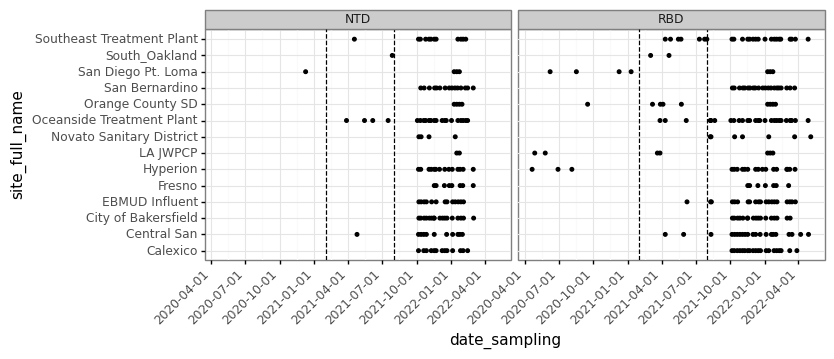

<ggplot: (381707298)>

In [442]:
samples_tracking = abund_all_df[['sample_code', 'site_full_name', 'date_sampling', 'amplicon']].copy().drop_duplicates()

drop = ['S_S_INF', 'Q_Q_CMF', 'O_O_INF', 'M_M_INF', 'J_J_PC', 'J_J_Kerr', 'B_B_INF', 'F_F_INF', 'B_B_SRWS', 'L_L_INF']
(ggplot(samples_tracking[~samples_tracking.sample_code.isin(drop)], aes(x='date_sampling', y='site_full_name'))+
geom_point(size=1)+
 geom_vline(xintercept='2021-08-01', linetype='dashed')+
 geom_vline(xintercept='2021-02-01', linetype='dashed')+
facet_wrap('~amplicon')+
theme_bw()+
theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 3)))

## Group sequences by lineage - manual definitions

### For RBD

In [477]:
# RBD variant definitions
variant_mutations_manual = {
'Alpha': {'N501Y', 'A570D'},
'Beta': {'K417N', 'E484K', 'N501Y'},
'Gamma': {'K417T', 'E484K', 'N501Y'},
'Delta': {'L452R', 'T478K'},
'Omicron BA.2': {'N501Y','Q493R', 'Q498R', 'S477N', 'T478K', 'Y505H'}}

#'Omicron BA.1': {'N440K', 'N501Y','Q493R', 'Q498R', 'S477N', 'T478K', 'Y505H', 'T547K', 'G496S'}, # the last 2 are BA.1 but not BA.2
#'Omicron BA.2.12.1': {'K417N', 'N440K', 'L452Q', 'S477N', 'T478K'},
#'Omicron BA.4/BA.5': {'K417N', 'N440K', 'L452R', 'F486V'}}

## U Missouri definitions

# "Omicron BA.1"   :   [1, ["K417N", "N440K", "G446S", ["not", "L452Q"], "S477N", "T478K", "1451C(E484A)", "1478G(Q493R)", "1486A(G496S)", "1493G(Q498R)", "1501T(N501Y)", "1513C(Y505H)", "1640A(T547K)"]],
# "Omicron BA.2"   :   [0, ["K417N", "N440K", ["not", "G446"],["not", "L452Q"],  "S477N", "1433A(T478K)", "1451C(E484A)", "1478G(Q493R)", ["not", "G496"], "1493G(Q498R)", "1501T(N501Y)", "1513C(Y505H)", ["not", "T547"]]],
# "Omicron BA.2.12.1"   :   [0, ["1251T(K417N)", "1320G(N440K)", ["not", "G446"], "1355A(L452Q)", "1430A(S477N)", "1433A(T478K)", "1451C(E484A)", "1478G(Q493R)", ["not", "G496"], "1493G(Q498R)", "1501T(N501Y)", "1513C(Y505H)", ["not", "T547"]]],
  
# 'Omicron BA.2.12.1': 'S:K417N,S:N440K,S:L452Q,S:S477N,S:T478K,S:E484A,S:Q493R,S:Q498R,S:501Y,S:Y505H'
# 'Omicron BA.2': 'S:K417N,S:N440K,S:S477N,S:T478K,S:E484A,S:Q493R,S:Q498R,S:N501Y,S:Y505H'
# 'Omicron BA.1': 'S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484A,S:Q493R,S:G496S,S:Q498R,S:N501Y,S:Y505H,S:T547K'

In [478]:
# Get table of unique sequences and their aa substitutions
amplicon = 'RBD'
rbd_filt_df = abund_all_df[(abund_all_df.amplicon == amplicon)].copy()
muts_df = rbd_filt_df[['Sequence', 'aaSubstitutions', 'aa_substitution_count']].copy().drop_duplicates()
muts_df['mutations'] = muts_df.aaSubstitutions.str.replace('S:', '')

variant = []
for r in muts_df.itertuples():
    mutations = set(r.mutations.split(','))
    # first check for Epsilon, if not that, then continue
    if {'L452R'}.issubset(mutations) and ('T478K' not in mutations) and r.aa_substitution_count < 4:
            variant.append([r.Sequence, 'Epsilon'])
    else:
        for key in variant_mutations_manual.keys():
            # check if indicator mutations are present and assign (include BA.2)
            if variant_mutations_manual[key].issubset(mutations):
                # if Omicron check whether additional mutations are present and tag as BA.1
                if {'T547K', 'G496S'}.issubset(mutations):
                    variant.append([r.Sequence, 'Omicron BA.1'])
                elif 'L452Q' in mutations:
                    variant.append([r.Sequence, 'Omicron BA.2.12.1'])
                elif {'L452R', 'F486V'}.issubset(mutations):
                    variant.append([r.Sequence, 'Omicron BA.4/BA.5'])
                else:
                    variant.append([r.Sequence, key])     

seq2variant = pd.DataFrame.from_records(variant, columns=['Sequence','variant'])
rbd_filt_df = rbd_filt_df.merge(seq2variant, how='left', on='Sequence') # if there is no variant, merging will fill with na
rbd_filt_df.loc[rbd_filt_df.variant.isna(), 'variant'] = 'other' # change na to other
rbd_filt_df.loc[(rbd_filt_df.aa_substitution_count<2) & 
                (~rbd_filt_df.variant.isin(['Alpha', 'Epsilon', 'Delta'])), 'variant'] = 'none'
rbd_filt_df = rbd_filt_df.drop(columns='aa_substitution_count')

# check that assignments are correct
# Alpha (yes)
# Beta (none)
# Gamma (yes)
# Delta - should be cryptic: Seq593, Seq696
# Omicron BA.2 (yes, probably)
# Omicron BA.1 (yes, probably)
# Omicron BA.2.12.1 (yes, probably)
# Omicron BA.4/BA.5 (yes, probably)

# manually fix mis-identified cryptic lineages
rbd_filt_df.loc[rbd_filt_df.Sequence.isin(['Seq593', 'Seq696']), 'variant'] = 'other'

# group on variant to sum total variants within samples
abund_grouped_sample = rbd_filt_df.groupby(['Sample', 'county', 'site_full_name', 'date_sampling', 'variant']).sum().reset_index()

# for duplicate samples (same site and date), take the mean abundance
abund_grouped = abund_grouped_sample[abund_grouped_sample.Abundance > 0].copy()
abund_grouped = abund_grouped.groupby(['county', 'site_full_name', 'date_sampling', 'variant']).agg('mean').reset_index()

In [479]:
rbd_filt_df[(rbd_filt_df.variant=='Epsilon') & (rbd_filt_df.Abundance > 0)]

Sample        county             site_full_name  \
1345    SDPU_PtLom_INF_060820_1     San Diego         San Diego Pt. Loma   
1357         D_OSP_INF_041121_1            SF  Oceanside Treatment Plant   
1364           K_K_INF_041121_2  Contra Costa                Central San   
1365           K_K_INF_053021_1  Contra Costa                Central San   
4176         D_OSP_INF_032821_1            SF  Oceanside Treatment Plant   
84405   SDPU_PtLom_INF_010922_1     San Diego         San Diego Pt. Loma   
125437       D_OSP_INF_041121_1            SF  Oceanside Treatment Plant   
125445         K_K_INF_053021_1  Contra Costa                Central San   
126377       D_OSP_INF_041121_1            SF  Oceanside Treatment Plant   
129666       D_OSP_INF_032821_1            SF  Oceanside Treatment Plant   

       date_sampling     sample_code Sequence  Abundance amplicon seqName  \
1345      2020-06-08  SDPU_PtLom_INF    Seq11  36.893985      RBD   Seq11   
1357      2021-04-11       D_OSP_INF    Seq11  99.769540      RBD   Seq11   
1364      2021-04-11         K_K_INF    Seq11  23.251809      RBD   Seq11   
1365      2021-05-30         K_K_INF    Seq11  99.895537      RBD   Seq11   
4176      2021-03-28       D_OSP_INF    Seq45  99.870920      RBD   Seq45   
84405     2022-01-09  SDPU_PtLom_INF   Seq394   1.026157      RBD  Seq394   
125437    2021-04-11       D_OSP_INF   Seq566   0.070784      RBD  Seq566   
125445    2021-05-30         K_K_INF   Seq566   0.104463      RBD  Seq566   
126377    2021-04-11       D_OSP_INF   Seq515   0.159676      RBD  Seq515   
129666    2021-03-28       D_OSP_INF   Seq674   0.129080      RBD  Seq674   

              clade            substitutions deletions insertions frameShifts  \
1345            19B                  T22917G                                    
1357            19B                  T22917G                                    
1364            19B                  T22917G                                    
1365            19B                  T22917G                                    
4176            19B                  T22917G     23051             S:497-1274   
84405   recombinant  T22917G,C22938A,C22995A     22927             S:456-1274   
125437          19B          G22801A,T22917G                                    
125445          19B          G22801A,T22917G                                    
126377          19B          T22917G,A22983G                                    
129666          19B          G22801A,T22917G     23051             S:497-1274   

        aaSubstitutions aaDeletions  variant  
1345            S:L452R              Epsilon  
1357            S:L452R              Epsilon  
1364            S:L452R              Epsilon  
1365            S:L452R              Epsilon  
4176            S:L452R              Epsilon  
84405           S:L452R     S:L455-  Epsilon  
125437          S:L452R              Epsilon  
125445          S:L452R              Epsilon  
126377  S:L452R,S:Q474R              Epsilon  
129666          S:L452R              Epsilon

In [480]:
# Save
rbd_filt_df[rbd_filt_df.Abundance>0].to_csv('/Users/rosekantor/data/wbe_scv/results_sgene/RBD_lineage_abundances.csv', index=False)
abund_grouped.to_csv('/Users/rosekantor/data/wbe_scv/results_sgene/RBD_lineage_abundances_summed.csv', index=False)

#### Examine duplicate samples

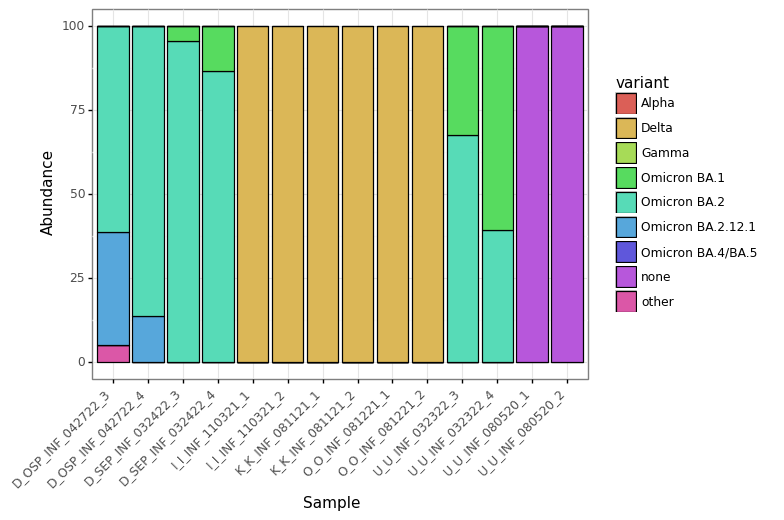

<ggplot: (376054010)>

In [457]:
t = abund_grouped_sample[['Sample', 'date_sampling', 'site_full_name']].drop_duplicates()
dupl = t[t.duplicated(['date_sampling', 'site_full_name'], keep=False)].Sample.to_list()

plt = (ggplot(abund_grouped_sample[abund_grouped_sample.Sample.isin(dupl)], aes(x='Sample', y='Abundance', fill='variant'))+
geom_bar(stat='identity', color='black')+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1)))
display(plt)
#ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/RBD_duplicated_samples_are_similar.png')

In [448]:
# filter to NWSS sites
nwss = ['Calexico', 'Central San', 'EBMUD Influent', 'City of Bakersfield', 
        'Fresno', 'Hyperion', 'Oceanside Treatment Plant', 'San Bernardino', 
        'Southeast Treatment Plant', 'LA JWPCP', 'Orange County SD', 'San Diego Pt Loma']

abund_grouped_renamed = abund_grouped[abund_grouped.site_full_name.isin(nwss)].copy()
abund_grouped_renamed.loc[abund_grouped_renamed.site_full_name == 'Oceanside Treatment Plant', 'county'] = 'San Francisco OSP'
abund_grouped_renamed.loc[abund_grouped_renamed.site_full_name == 'Southeast Treatment Plant', 'county'] = 'San Francisco SEP'

In [449]:
# plt = (ggplot(abund_grouped_sample[abund_grouped_sample.date_sampling < '2021-08-01'], aes(x='Sample', y='Abundance', fill='variant'))+
# geom_bar(stat='identity', color='black')+
# theme_bw()+
# theme(axis_text_x=element_text(angle=45, hjust=1))+
# facet_wrap('~county + site_full_name', ncol=2, scales='free_x'))
# display(plt)
# #ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/RBD_duplicated_samples_are_similar.png')

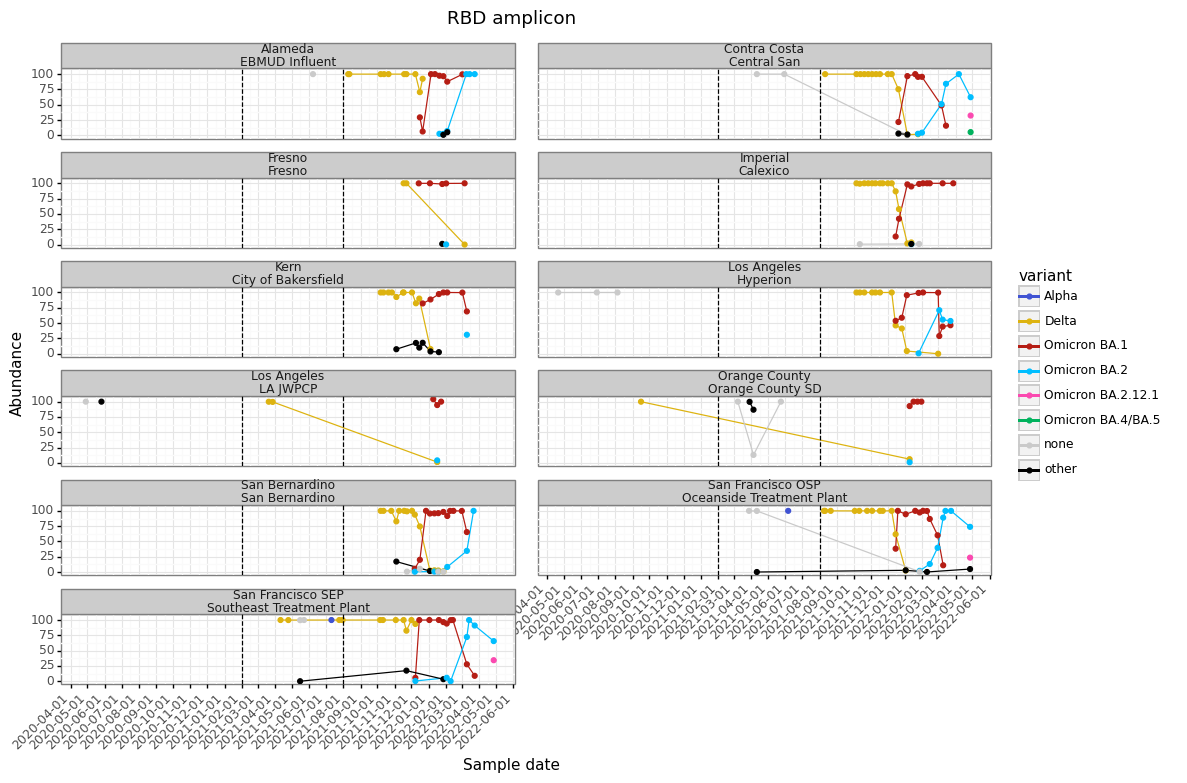

<ggplot: (686703132)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 8 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/figures/RBD_lineage_abund_linear_with_archive.png


In [450]:
colors = ['#4053d3','#ddb310','#b51d14','#00beff','#fb49b0','#00b25d','#cacaca', 'black', 'white']

plt = (ggplot(abund_grouped_renamed, 
        aes(y='Abundance', x='date_sampling', color='variant'))+
geom_line()+
geom_point()+
geom_vline(xintercept='2021-08-01', linetype='dashed')+
geom_vline(xintercept='2021-02-01', linetype='dashed')+
scale_color_manual(values=colors)+
#facet_grid('site_full_name~')+
facet_wrap('~county + site_full_name', ncol=2)+
scale_x_datetime(breaks = '1 month')+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(subplots_adjust={'wspace': 0.05})+
theme(figure_size=(12,8), axis_text_x=element_text(angle=45, hjust=1, size=9)))

display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/figures/RBD_lineage_abund_linear_with_archive.png')

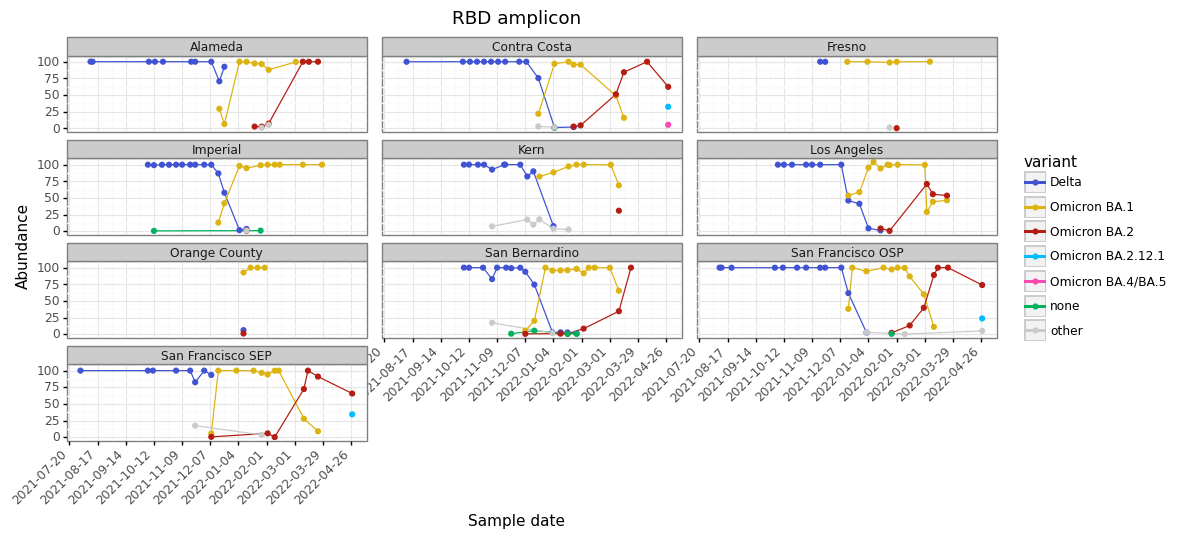

<ggplot: (686528088)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 5 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/figures/RBD_lineage_abund_linear_prospective.png


In [396]:
colors = ['#4053d3','#ddb310','#b51d14','#00beff','#fb49b0','#00b25d','#cacaca']

plt = (ggplot(abund_grouped_renamed[abund_grouped_renamed.date_sampling > '2021-07-27'], 
        aes(y='Abundance', x='date_sampling', color='variant'))+
geom_line()+
geom_point()+
scale_color_manual(values=colors)+
#facet_grid('site_full_name~')+
facet_wrap('~county', ncol=3)+
scale_x_datetime(breaks = '4 weeks')+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(subplots_adjust={'wspace': 0.05})+
theme(figure_size=(12,5), axis_text_x=element_text(angle=45, hjust=1)))

display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/figures/RBD_lineage_abund_linear_prospective.png')

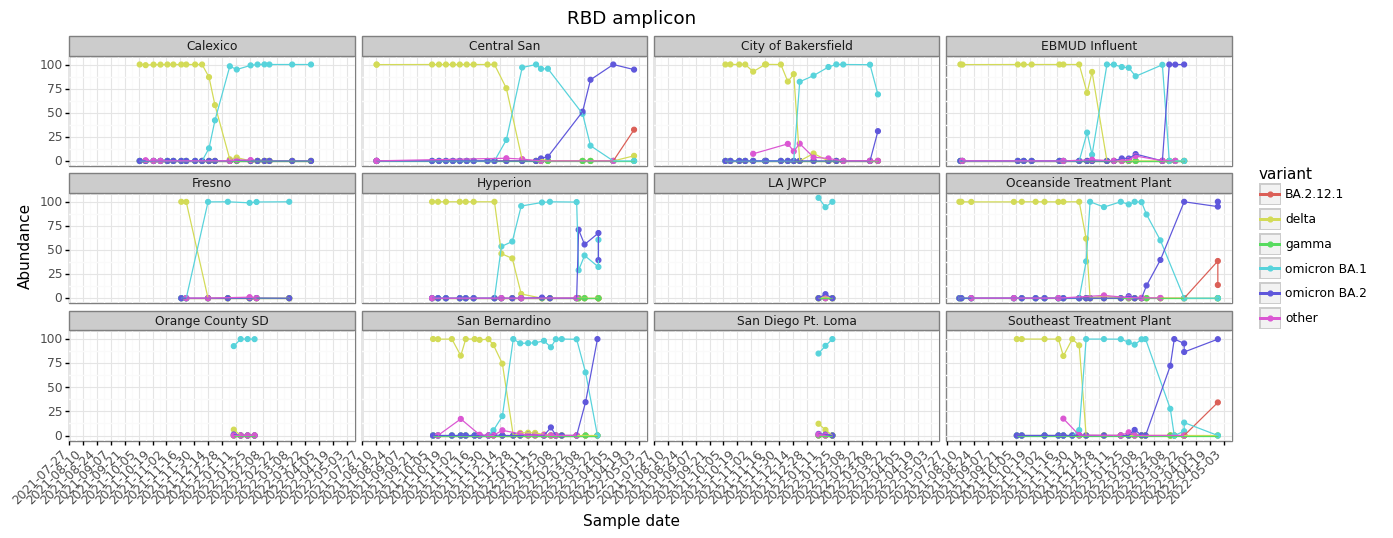

<ggplot: (339670251)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/figures/RBD_lineage_abund_linear.png


In [366]:
nwss = ['Calexico', 'Central San', 'EBMUD Influent', 'City of Bakersfield', 
        'Fresno', 'Hyperion', 'Oceanside Treatment Plant', 'San Bernardino', 
        'Southeast Treatment Plant', 'LA JWPCP', 'Orange County SD', 'San Diego Pt. Loma'] # 
#colors = ['#66c2a5','#fc8d62','#8da0cb']
plt = (ggplot(abund_grouped[abund_grouped.site_full_name.isin(nwss)], 
        aes(y='Abundance', x='date_sampling', color='variant'))+
geom_point()+
geom_line()+
#scale_color_manual(values=colors)+
#facet_grid('site_full_name~')+
facet_wrap('~site_full_name', ncol=4)+
scale_x_datetime(breaks = '2 weeks')+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(15,5), axis_text_x=element_text(angle=45, hjust=1)))

display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/figures/RBD_lineage_abund_linear.png')

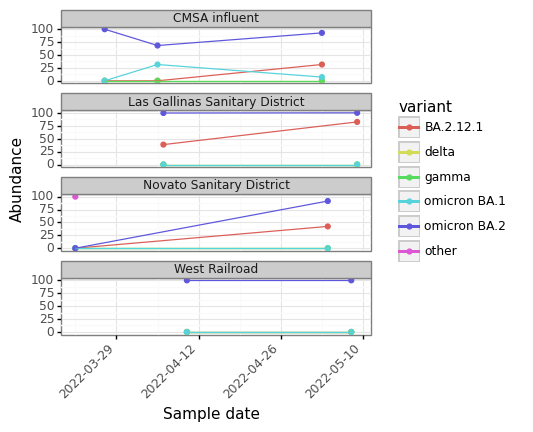

<ggplot: (355112340)>

In [377]:
marin_sites = ['Novato Sanitary District', 'CMSA influent', 'Las Gallinas Sanitary District', 'West Railroad']
plt = (ggplot(abund_grouped[(abund_grouped.site_full_name.isin(marin_sites)) & 
                            (abund_grouped.date_sampling > '2022-03-01')], 
        aes(y='Abundance', x='date_sampling', color='variant'))+
geom_point()+
geom_line()+
#scale_color_manual(values=colors)+
#facet_grid('site_full_name~')+
facet_wrap('~site_full_name', ncol=1)+
scale_x_datetime(breaks = '2 weeks')+
#ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(4,4), axis_text_x=element_text(angle=45, hjust=1)))

display(plt)

In [50]:
abund_grouped[(abund_grouped.variant == 'omicron BA.2') & (abund_grouped.Abundance > 0)].sort_values('date_sampling')
#abund_grouped[(abund_grouped.variant == 'omicron') & (abund_grouped.Abundance > 0)].sort_values('date_sampling').head(10)

Sample          county             site_full_name  \
401         W_W_INF_120721_3  San Bernardino             San Bernardino   
143       D_SEP_INF_120821_1              SF  Southeast Treatment Plant   
233     OCSD_P1_INF_010922_1   Orange County           Orange County SD   
251  SDPU_PtLom_INF_010922_1       San Diego         San Diego Pt. Loma   
356         W_W_INF_011122_4  San Bernardino             San Bernardino   
302         V_V_INF_011222_4        Imperial                   Calexico   
149         I_I_INF_011222_4           Marin   Novato Sanitary District   
218   LACSD_Jnt_INF_011622_1     Los Angeles                   LA JWPCP   
254  SDPU_PtLom_INF_011622_1       San Diego         San Diego Pt. Loma   
359         W_W_INF_011822_4  San Bernardino             San Bernardino   
8           C_C_INF_012022_4         Alameda             EBMUD Influent   
173         K_K_INF_012422_4    Contra Costa                Central San   
263         U_U_INF_012522_4     Los Angeles                   Hyperion   
11          C_C_INF_012722_4         Alameda             EBMUD Influent   
56        D_OSP_INF_012722_4              SF  Oceanside Treatment Plant   
176         K_K_INF_013122_4    Contra Costa                Central San   
464         Y_Y_INF_020122_4          Fresno                     Fresno   
116       D_SEP_INF_020222_4              SF  Southeast Treatment Plant   
14          C_C_INF_020322_4         Alameda             EBMUD Influent   
365         W_W_INF_020322_4  San Bernardino             San Bernardino   
65        D_OSP_INF_021422_1              SF  Oceanside Treatment Plant   
68        D_OSP_INF_022822_1              SF  Oceanside Treatment Plant   

    date_sampling       variant  Abundance  aa_substitution_count  
401    2021-12-07  omicron BA.2        0.6                   30.0  
143    2021-12-08  omicron BA.2        0.5                   30.0  
233    2022-01-09  omicron BA.2        1.1                   30.0  
251    2022-01-09  omicron BA.2        1.7                   30.0  
356    2022-01-11  omicron BA.2        0.9                   30.0  
302    2022-01-12  omicron BA.2        0.7                   30.0  
149    2022-01-12  omicron BA.2        3.3                   30.0  
218    2022-01-16  omicron BA.2        4.2                   30.0  
254    2022-01-16  omicron BA.2        1.0                   30.0  
359    2022-01-18  omicron BA.2        0.6                   30.0  
8      2022-01-20  omicron BA.2        2.6                   30.0  
173    2022-01-24  omicron BA.2        2.6                   30.0  
263    2022-01-25  omicron BA.2        0.7                   30.0  
11     2022-01-27  omicron BA.2        2.5                   30.0  
56     2022-01-27  omicron BA.2        2.1                   30.0  
176    2022-01-31  omicron BA.2        4.4                   30.0  
464    2022-02-01  omicron BA.2        0.2                   30.0  
116    2022-02-02  omicron BA.2        5.8                   30.0  
14     2022-02-03  omicron BA.2        7.1                   30.0  
365    2022-02-03  omicron BA.2        8.4                   30.0  
65     2022-02-14  omicron BA.2       13.2                   30.0  
68     2022-02-28  omicron BA.2       39.7                   30.0

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10


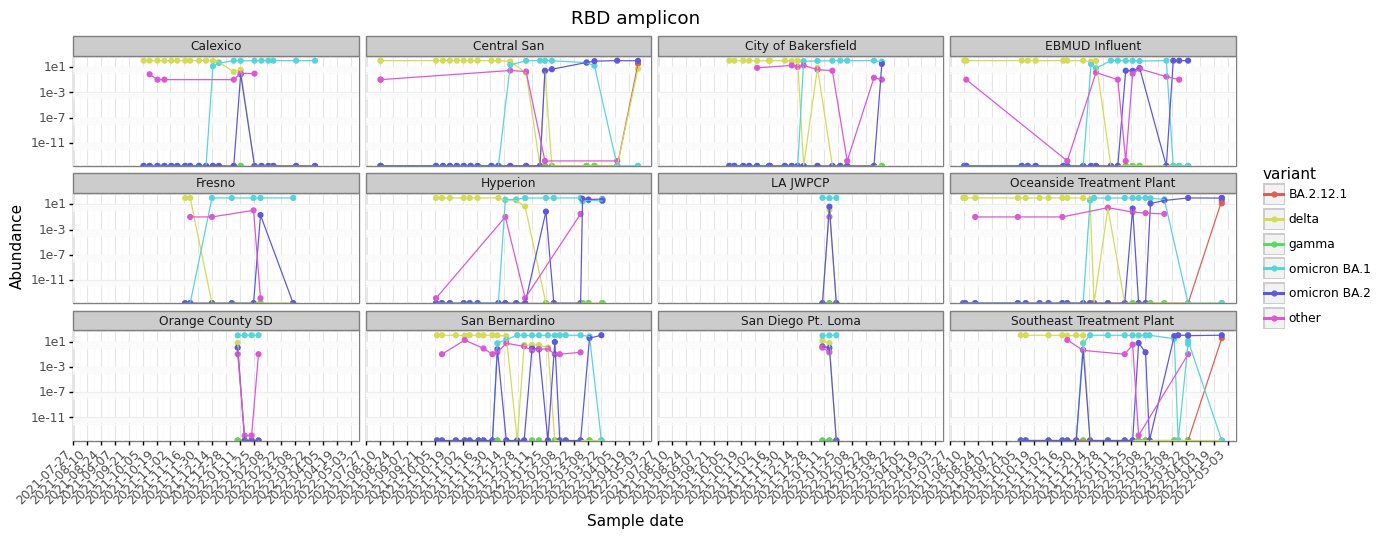

<ggplot: (339830372)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 15 x 5 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/figures/lineage_abund_log.png
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10


In [420]:
nwss = ['Calexico', 'Central San', 'EBMUD Influent', 'City of Bakersfield', 
        'Fresno', 'Hyperion', 'Oceanside Treatment Plant', 'San Bernardino', 
        'Southeast Treatment Plant', 'LA JWPCP', 'Orange County SD', 'San Diego Pt. Loma']
#colors = ['#66c2a5','#fc8d62','#8da0cb']
plt = (ggplot(abund_grouped[abund_grouped.site_full_name.isin(nwss)], 
        aes(y='Abundance', x='date_sampling', color='variant'))+
geom_point()+
geom_line()+
#scale_color_manual(values=colors)+
#facet_grid('site_full_name~')+
facet_wrap('~site_full_name', ncol=4)+
scale_x_datetime(breaks = '2 weeks')+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
scale_y_log10()+
theme_bw()+
theme(figure_size=(15,5), axis_text_x=element_text(angle=45, hjust=1)))

display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/figures/lineage_abund_log.png')

In [20]:
# In recent samples, what else is there besides Omicron?
abund_all_filt_df[(abund_all_filt_df.Abundance > 0) &
                  (abund_all_filt_df.variant != 'omicron') &
                  (abund_all_filt_df.variant != 'delta') &
                  (abund_all_filt_df.date_sampling >= '2022-02-01')
                 ][['seqName', 'clade', 'aaSubstitutions', 'frameShifts']].drop_duplicates()#.aaSubstitutions.values

seqName        clade                                    aaSubstitutions  \
1490     Seq7  recombinant  S:K417N,S:N440K,S:S477N,S:T478K,S:E484A,S:Q493...   
17764   Seq62  recombinant  S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
25190   Seq93  recombinant  S:K417N,S:L425V,S:N440K,S:S477N,S:T478K,S:E484...   
36252  Seq329  recombinant                            S:K417N,S:N440K,S:G446S   

      frameShifts  
1490               
17764              
25190              
36252  S:475-1274

### For NTD

In [41]:
variant_mutations_manual = {
'delta': {'R158G'},
'omicron BA.1 or BA.3': {'A67V', 'T95I'},
'omicron BA.2': {'Y145D', 'V213G'}}

In [42]:
# Classify based on the manual list of mutations
amplicon = 'NTD'
abund_all_filt_df = abund_all_df[(abund_all_df.amplicon == amplicon) &
                             (~abund_all_df.Sample.str.startswith('control')) &
                             (abund_all_df.Sample != 'K_K_INF_111721_1')].copy()
abund_all_muts_df = abund_all_filt_df[['Sequence', 'aaSubstitutions']].drop_duplicates().sort_values('Sequence').copy()

variant = []
for r in abund_all_muts_df.itertuples():
    mutations = r.aaSubstitutions.replace('S:', '')
    mutations = set(mutations.split(','))
    for key in variant_mutations_manual.keys():
        # tricky to ask whether all indicator mutations are present
        if variant_mutations_manual[key].issubset(mutations):
            variant.append([r.Sequence, key])     

seq2variant = pd.DataFrame.from_records(variant, columns=['Sequence','variant'])
abund_all_filt_df = abund_all_filt_df.merge(seq2variant, how='left', on='Sequence')

# group on variant to sum total variants within samples
abund_grouped = abund_all_filt_df.groupby(['Sample', 'county', 'site_full_name', 'date_sampling', 'variant']).sum().reset_index()

# sum total and subtract from 100% to get other lineages
other_lineages_abund = []
for [s,c,n,d],df in abund_grouped.groupby(['Sample', 'county', 'site_full_name', 'date_sampling']):
    other_abund = 100 - df.Abundance.sum()
    if other_abund > 0:
        other_lineages_abund.append([s, c, n, d, 'other', other_abund])
        
other_lineages_abund_df = pd.DataFrame.from_records(other_lineages_abund, columns=['Sample', 'county', 'site_full_name', 'date_sampling', 'variant', 'Abundance'])
abund_grouped = abund_grouped.append(other_lineages_abund_df)

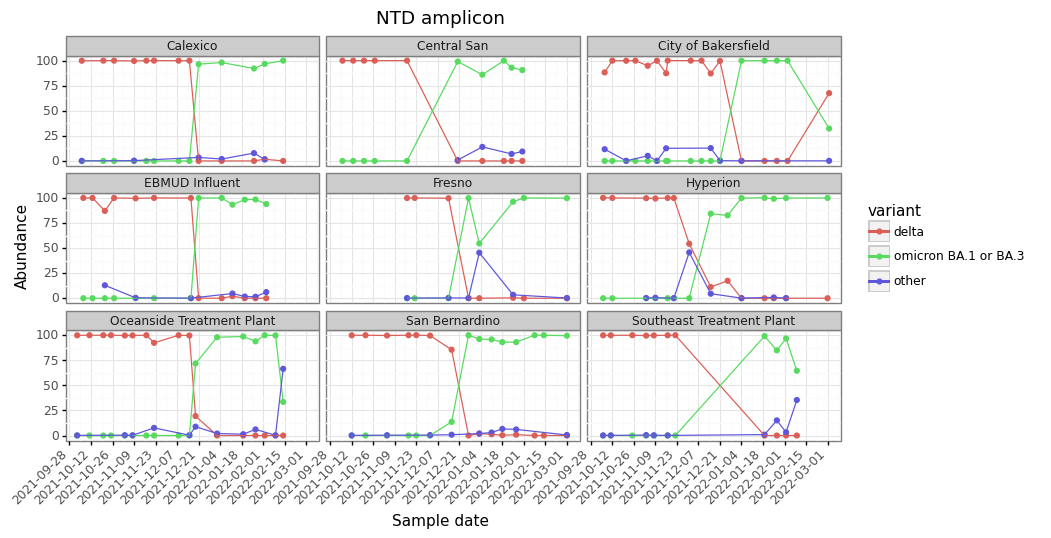

<ggplot: (377292532)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 5 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/figures/NTD_lineage_abund_log.png


In [43]:
nwss = ['Calexico', 'Central San', 'EBMUD Influent', 'City of Bakersfield', 
        'Fresno', 'Hyperion', 'Oceanside Treatment Plant', 'San Bernardino', 
        'Southeast Treatment Plant'] # 'LA JWPCP', 'Orange County SD', 'San Diego Pt Loma'
#colors = ['#66c2a5','#fc8d62','#8da0cb']
plt = (ggplot(abund_grouped[abund_grouped.site_full_name.isin(nwss)], 
        aes(y='Abundance', x='date_sampling', color='variant'))+
geom_point()+
geom_line()+
#scale_color_manual(values=colors)+
#facet_grid('site_full_name~')+
facet_wrap('~site_full_name', ncol=3)+
scale_x_datetime(breaks = '2 weeks')+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/figures/NTD_lineage_abund_log.png')

## Plot most abundant seqs over time

In [401]:
# plot shifting abundance of all seqs that were ever >10% in any sample

amplicon = 'RBD'
# get list of seqs that were at least 50% abundance at some point
abund_hi_seqs = abund_all_df[(abund_all_df.amplicon == amplicon) &
                             (~abund_all_df.Sample.str.startswith('control')) &
                             (abund_all_df.Abundance >= 40) &
                             (abund_all_df.Sample != 'K_K_INF_111721_1')].Sequence.unique() # drop this weird sample].Sequence.unique()


abund_hi_seqs_df = abund_all_df[(abund_all_df.amplicon == amplicon) &
                                (~abund_all_df.Sample.str.startswith('control')) &
                                (abund_all_df.Sequence.isin(abund_hi_seqs)) &
                                (abund_all_df.Sample != 'K_K_INF_111721_1')].copy()

# collapse on amino acid mutations so that synonymous seqs merge together
abund_hi_seqs_df = abund_hi_seqs_df.groupby(['Sample', 'county', 'site_full_name', 'date_sampling', 'aaSubstitutions']).sum().reset_index()

abund_hi_seqs_df = abund_hi_seqs_df[abund_hi_seqs_df.Abundance > 0]

sample_counts = abund_hi_seqs_df.groupby('site_full_name').count().reset_index().sort_values('Sample', ascending=False)
longterm_sites = sample_counts[sample_counts.Sample>20].site_full_name.to_list()
shortterm_sites = sample_counts[sample_counts.Sample<=20].site_full_name.to_list()

longterm_abund_hi = abund_hi_seqs_df[abund_hi_seqs_df.site_full_name.isin(longterm_sites)].copy()

In [402]:
longterm_abund_hi.aaSubstitutions.unique()

array(['S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484A,S:Q493R,S:G496S,S:Q498R,S:N501Y,S:Y505H,S:T547K',
       'S:K417N,S:N440K,S:S477N,S:T478K,S:E484A,S:Q493R,S:Q498R,S:N501Y,S:Y505H',
       'S:K417N,S:L452R,S:T478K', 'S:L452R,S:T478K',
       'S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484A,S:Q493R,S:G496S,S:Q498R,S:N501Y,S:Y505H,S:T547K,S:D568N',
       'S:K417N,S:N440K,S:L452Q,S:S477N,S:T478K,S:E484A,S:Q493R,S:Q498R,S:N501Y,S:Y505H',
       'S:L452R,S:T478K,S:Y508F',
       'S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484A,S:Y489F,S:Q493R,S:G496S,S:Q498R,S:N501Y,S:Y505H,S:T547K',
       'S:L452R,S:L455F,S:T478K', 'S:L452R,S:Q474H,S:T478K'], dtype=object)

In [403]:

aaSubstitutions_ordered = [
 'S:L452R,S:T478K',
 'S:K417N,S:L452R,S:T478K',
 'S:L452R,S:L455F,S:T478K',
 'S:L452R,S:Q474H,S:T478K',
 'S:L452R,S:T478K,S:Y508F',
 'S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484A,S:Q493R,S:G496S,S:Q498R,S:N501Y,S:Y505H,S:T547K',
 'S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484A,S:Q493R,S:G496S,S:Q498R,S:N501Y,S:Y505H,S:T547K,S:D568N',
 'S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484A,S:Y489F,S:Q493R,S:G496S,S:Q498R,S:N501Y,S:Y505H,S:T547K',
 'S:K417N,S:N440K,S:S477N,S:T478K,S:E484A,S:Q493R,S:Q498R,S:N501Y,S:Y505H',
 'S:K417N,S:N440K,S:L452Q,S:S477N,S:T478K,S:E484A,S:Q493R,S:Q498R,S:N501Y,S:Y505H',
]

longterm_abund_hi['aaSubstitutions'] = pd.Categorical(longterm_abund_hi['aaSubstitutions'], ordered=True, categories=aaSubstitutions_ordered)

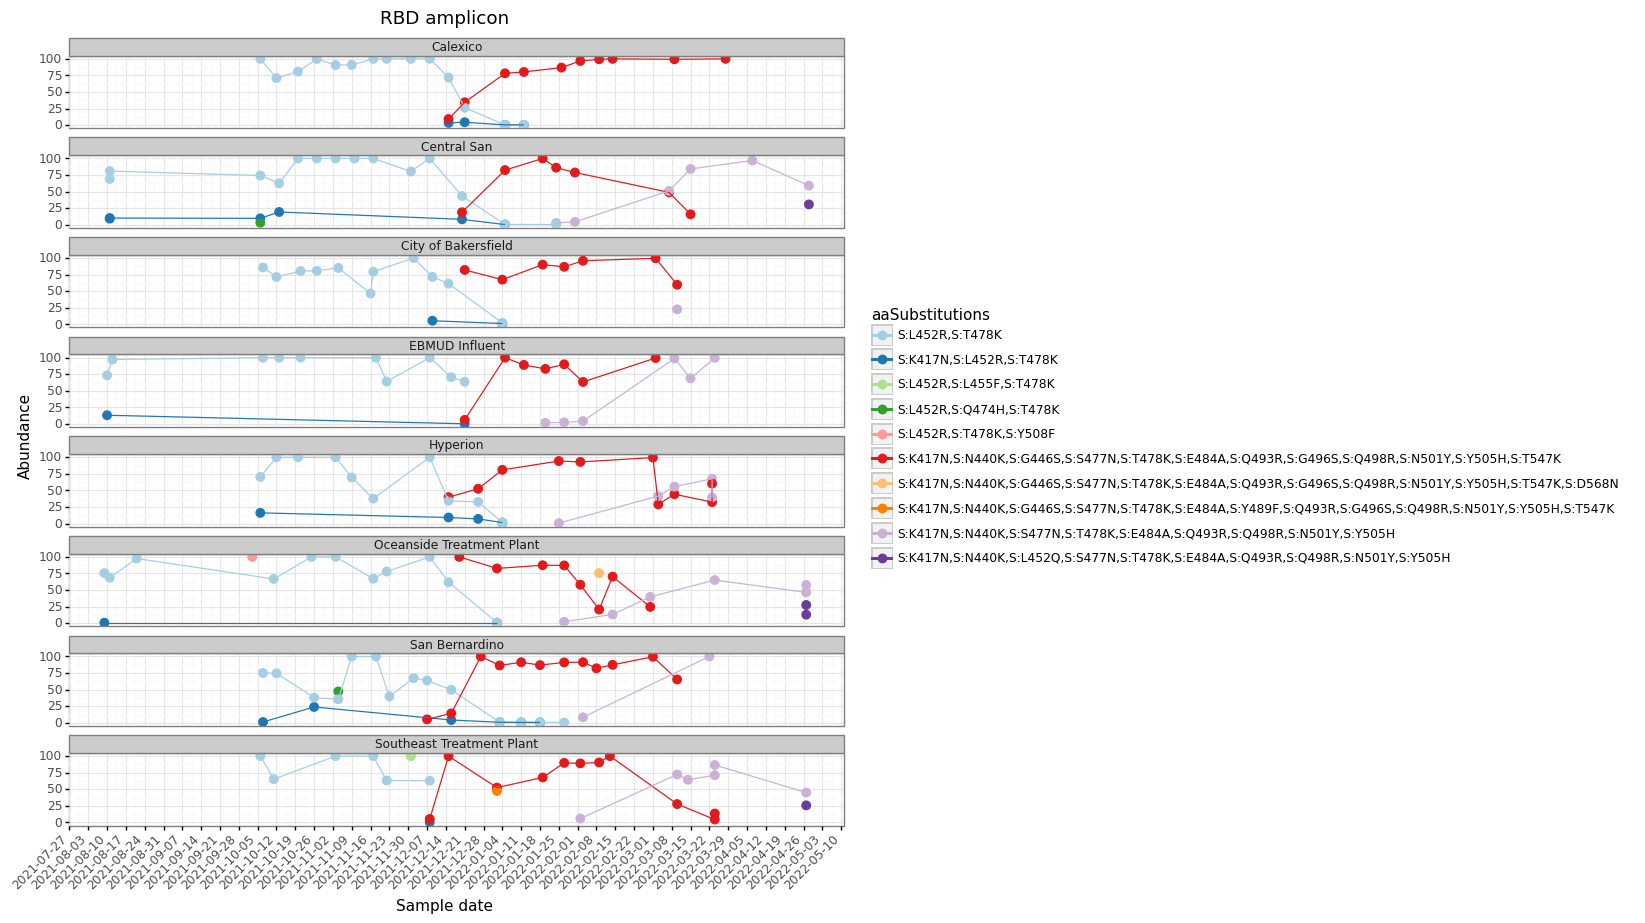

<ggplot: (339531249)>

In [404]:
# plot long term sites

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
(ggplot(longterm_abund_hi, 
        aes(y='Abundance', x='date_sampling', color='aaSubstitutions'))+
geom_point(size=3)+
geom_line()+
scale_color_manual(values=colors)+
scale_x_datetime(breaks='1 weeks')+
#facet_grid('site_full_name~')+
facet_wrap('~site_full_name', ncol=1)+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(10,10), axis_text_x=element_text(angle=45, hjust=1))) #, legend_position=(.5, -.1)

In [407]:
longterm_abund_hi.site_full_name.unique()

array(['EBMUD Influent', 'Oceanside Treatment Plant',
       'Southeast Treatment Plant', 'Central San', 'Hyperion', 'Calexico',
       'San Bernardino', 'City of Bakersfield'], dtype=object)

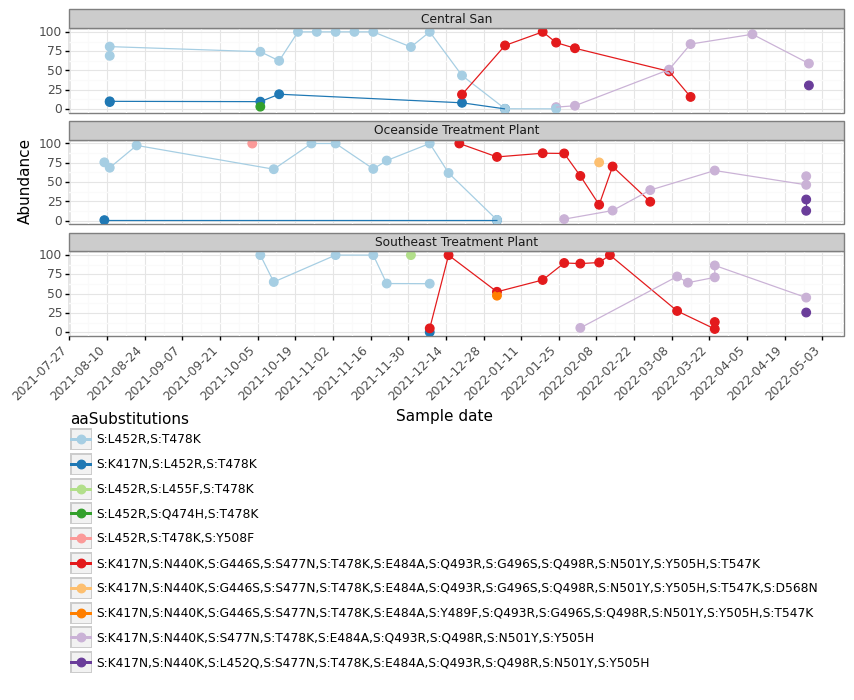

<ggplot: (315862781)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 4 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/figures/RBD_timeseries_K_D.png


In [418]:
# plot long term sites

longest = ['Oceanside Treatment Plant',
       'Southeast Treatment Plant', 'Central San']

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
plt = (ggplot(longterm_abund_hi[longterm_abund_hi.site_full_name.isin(longest)], 
        aes(y='Abundance', x='date_sampling', color='aaSubstitutions'))+
geom_point(size=3)+
geom_line()+
scale_color_manual(values=colors)+
scale_x_datetime(breaks='2 weeks')+
#facet_grid('site_full_name~')+
facet_wrap('~site_full_name', ncol=1)+
#ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(10,4), axis_text_x=element_text(angle=45, hjust=1), legend_position=(.5, -.4))# legend_position='none'
)

display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/figures/RBD_timeseries_K_D.png')

In [79]:
# plot shifting abundance of all seqs that were ever >10% in any sample

amplicon = 'NTD'
# get list of seqs that were at least 50% abundance at some point
abund_hi_seqs = abund_all_df[(abund_all_df.amplicon == amplicon) &
                             (~abund_all_df.Sample.str.startswith('control')) &
                             (abund_all_df.Abundance >= 40) &
                             (abund_all_df.Sample != 'K_K_INF_111721_1')].Sequence.unique() # drop this weird sample].Sequence.unique()


abund_hi_seqs_df = abund_all_df[(abund_all_df.amplicon == amplicon) &
                                (~abund_all_df.Sample.str.startswith('control')) &
                                (abund_all_df.Sequence.isin(abund_hi_seqs)) &
                                (abund_all_df.Sample != 'K_K_INF_111721_1')].copy()

# collapse on amino acid mutations so that synonymous seqs merge together
abund_hi_seqs_df = abund_hi_seqs_df.groupby(['Sample', 'county', 'site_full_name', 'date_sampling', 'aaSubstitutions']).sum().reset_index()

abund_hi_seqs_df = abund_hi_seqs_df[abund_hi_seqs_df.Abundance > 0]

sample_counts = abund_hi_seqs_df.groupby('site_full_name').count().reset_index().sort_values('Sample', ascending=False)
longterm_sites = sample_counts[sample_counts.Sample>20].site_full_name.to_list()
shortterm_sites = sample_counts[sample_counts.Sample<=20].site_full_name.to_list()

longterm_abund_hi = abund_hi_seqs_df[abund_hi_seqs_df.site_full_name.isin(longterm_sites)].copy()

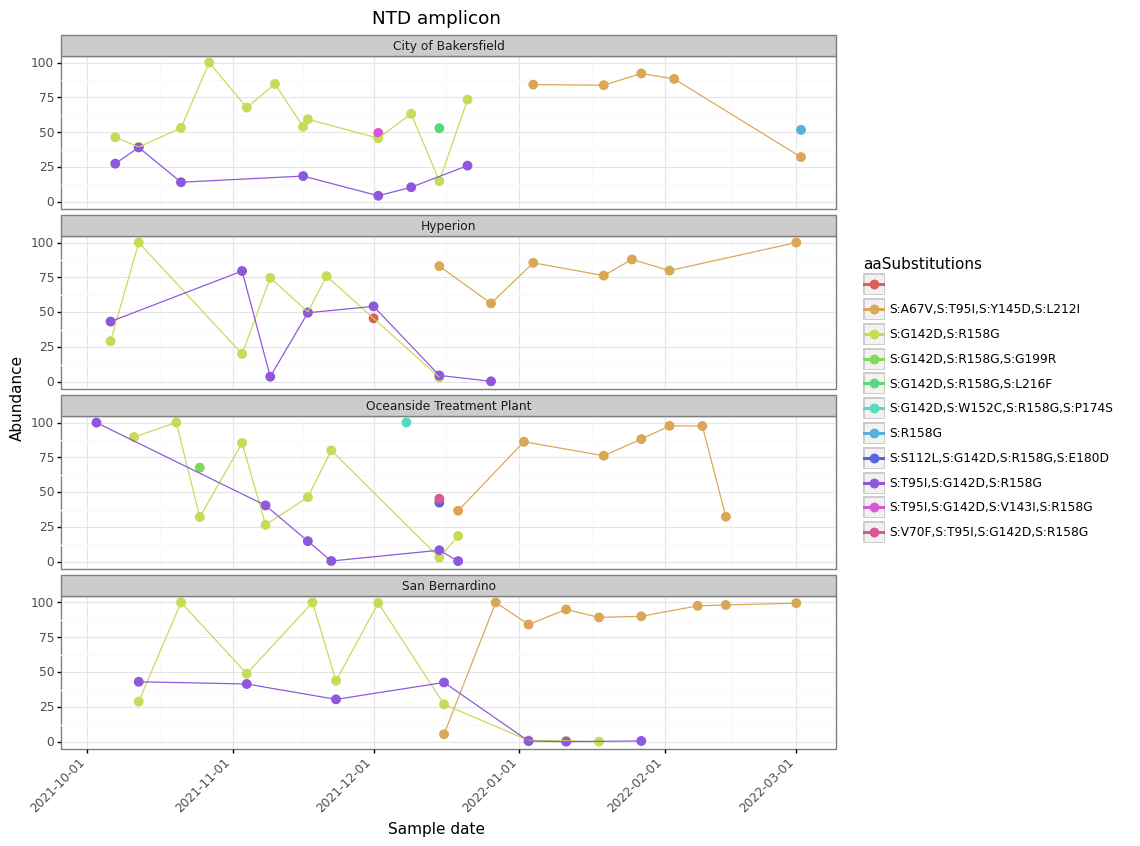

<ggplot: (317633524)>

In [81]:
# plot long term sites

#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
(ggplot(longterm_abund_hi, 
        aes(y='Abundance', x='date_sampling', color='aaSubstitutions'))+
geom_point(size=3)+
geom_line()+
#scale_color_manual(values=colors)+
#facet_grid('site_full_name~')+
facet_wrap('~site_full_name', ncol=1)+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(10,9), axis_text_x=element_text(angle=45, hjust=1))) #, legend_position=(.5, -.1)

## Explore low abundance sequences

Explore delta, Omicron, BA.2, BA.2.12.1

Explore unassigned seqs

In [309]:
rbd_filt_df['week'] = rbd_filt_df.date_sampling.dt.isocalendar().week
rbd_filt_df['year'] = rbd_filt_df.date_sampling.dt.isocalendar().year
rbd_filt_df['yr_wk'] = rbd_filt_df.year.astype('string') + "_" + rbd_filt_df.week.astype('string')
rbd_filt_df = rbd_filt_df.drop(columns = ['week', 'year'])
rbd_filt_df.head()

Sample        county             site_full_name date_sampling  \
1    C_C_INF_122121_3       Alameda             EBMUD Influent    2021-12-21   
2  D_OSP_INF_010222_1            SF  Oceanside Treatment Plant    2022-01-02   
5    K_K_INF_010522_1  Contra Costa                Central San    2022-01-05   
6    K_K_INF_122021_1  Contra Costa                Central San    2021-12-20   
7    U_U_INF_010422_1   Los Angeles                   Hyperion    2022-01-04   

  sample_code Sequence  Abundance amplicon seqName        clade  \
1     C_C_INF     Seq1       63.7      RBD    Seq1  recombinant   
2   D_OSP_INF     Seq1        1.1      RBD    Seq1  recombinant   
5     K_K_INF     Seq1        0.5      RBD    Seq1  recombinant   
6     K_K_INF     Seq1       43.5      RBD    Seq1  recombinant   
7     U_U_INF     Seq1        1.8      RBD    Seq1  recombinant   

     substitutions deletions insertions frameShifts  aaSubstitutions  \
1  T22917G,C22995A                                   S:L452R,S:T478K   
2  T22917G,C22995A                                   S:L452R,S:T478K   
5  T22917G,C22995A                                   S:L452R,S:T478K   
6  T22917G,C22995A                                   S:L452R,S:T478K   
7  T22917G,C22995A                                   S:L452R,S:T478K   

  aaDeletions  aa_substitution_count variant  week_yr    yr_wk  
1                                  2   delta  51_2021  2021_51  
2                                  2   delta  52_2021  2021_52  
5                                  2   delta   1_2022   2022_1  
6                                  2   delta  51_2021  2021_51  
7                                  2   delta   1_2022   2022_1

In [344]:
var = 'omicron BA.1'#'delta'#

rbd_filt_var_df = rbd_filt_df[(rbd_filt_df.variant == var) & (rbd_filt_df.Abundance > 0)].copy()
rbd_filt_var_df = rbd_filt_var_df.drop(columns=['seqName', 'variant', 'amplicon', 'clade', 'date_sampling'])

rbd_filt_var_df = rbd_filt_var_df.groupby([#'Sequence', # remove bc we don't care about synonymous SNPs
                                                    #'substitutions', # remove bc we don't care about synonymous SNPs
                                                    'aaSubstitutions', 
                                                    'aa_substitution_count', 
                                                    'deletions',
                                                    'aaDeletions',
                                                    'insertions',
                                                    'frameShifts']).agg(
    {'Sample': 'count',
     'yr_wk':['min', 'max', 'count'],
     'sample_code': [lambda x: list(x), pd.Series.nunique],
     'Abundance':['min', 'max', 'mean'], 
     }).reset_index() #

# get additional mutations

ba1_set = {'K417N', 'N440K', 'G446S', 'E484A', 'N501Y','Q493R', 'Q498R', 'S477N', 'T478K', 'Y505H', 'T547K', 'G496S'}

delta_set = {'L452R', 'T478K'}

rbd_filt_var_df['aaSubstitutions'] = rbd_filt_var_df['aaSubstitutions'].str.replace('S:', '')
rbd_filt_var_df['additional_mutations'] = rbd_filt_var_df.aaSubstitutions.str.split(',').apply(lambda x: ', '.join(set(x) - ba1_set))
rbd_filt_var_df['additional_mutations'] = rbd_filt_var_df['additional_mutations'].astype('string')

rbd_filt_var_df.columns = [#'Sequence', # remove bc we don't care about synonymous SNPs
                                  #'substitutions', # remove bc we don't care about synonymous SNPs
                                  'aaSubstitutions', 
                                  'aa_substitution_count', 'deletions', 'aaDeletions', 
                                  'insertions','frameShifts',
                                  'sample_count', 'date_min', 'date_max', 'date_unique', 
                                  'location_list', 'location_unique', 
                                  'abundance_min', 'abundance_max', 'abundance_mean',
                                  'additional_mutations'
]

rbd_filt_var_df['mutations'] = rbd_filt_var_df.additional_mutations + ' ' + rbd_filt_var_df.frameShifts + ' ' + rbd_filt_var_df.deletions

# rbd_filt_var_df[rbd_filt_var_df.sample_count > 1].shape # 47
# rbd_filt_var_df[rbd_filt_var_df.sample_count == 1].shape # 150

In [347]:
rbd_filt_var_df[rbd_filt_var_df.mutations == '  ']

aaSubstitutions  aa_substitution_count  \
25   K417N,G446S,S477N,T478K,E484A,Q493R,G496S,Q498...                     11   
112  K417N,N440K,G446S,S477N,T478K,E484A,Q493R,G496...                     12   
193  N440K,G446S,S477N,T478K,E484A,Q493R,G496S,Q498...                     11   

    deletions aaDeletions insertions frameShifts  sample_count date_min  \
25                                                           1   2022_3   
112                                                        234  2021_49   
193                                                         23  2021_49   

    date_max  date_unique                                      location_list  \
25    2022_3            1                                    [LACSD_Jnt_INF]   
112   2022_9          233  [C_C_INF, C_C_INF, D_OSP_INF, D_OSP_INF, D_SEP...   
193   2022_3           23  [C_C_INF, D_OSP_INF, K_K_INF, K_K_INF, U_U_INF...   

     location_unique  abundance_min  abundance_max  abundance_mean  \
25                 1            3.0            3.0        3.000000   
112               16            0.1          100.0       29.589316   
193               11            0.2            8.0        2.121739   

    additional_mutations mutations  
25                                  
112                                 
193

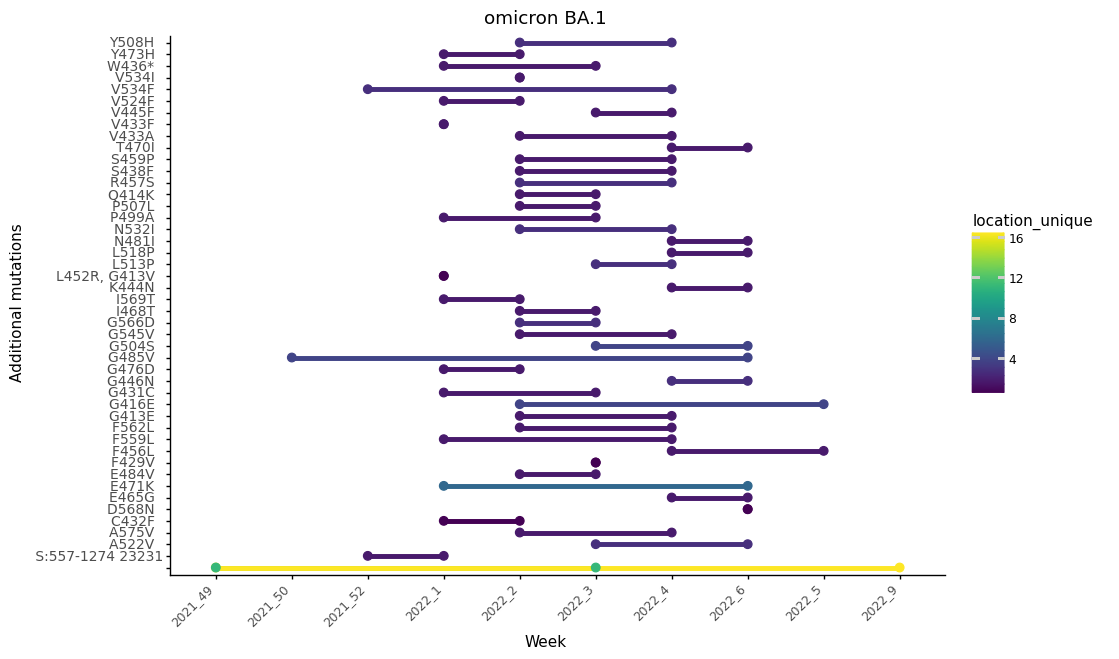

<ggplot: (317087754)>

In [354]:
# learned how to make this type of plot here: 
# https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_segment.html

(ggplot(rbd_filt_var_df[rbd_filt_var_df.sample_count > 1], aes(y='mutations'))+
geom_segment(aes(x='date_min', xend='date_max',
                yend='mutations',
                 color='location_unique'), size=2)+
geom_point(aes(x='date_min',  color='location_unique'), size=3)+
geom_point(aes(x='date_max', color='location_unique'), size=3)+

#geom_text(aes(y='additional_mutations', x='date_max', label='abundance_mean'))+
theme_classic()+
ggtitle(var)+
xlab('Week')+
ylab('Additional mutations')+
theme(figure_size=(10,7), axis_text_x=element_text(angle=45, hjust=1), axis_text_y=element_text(size=10)))

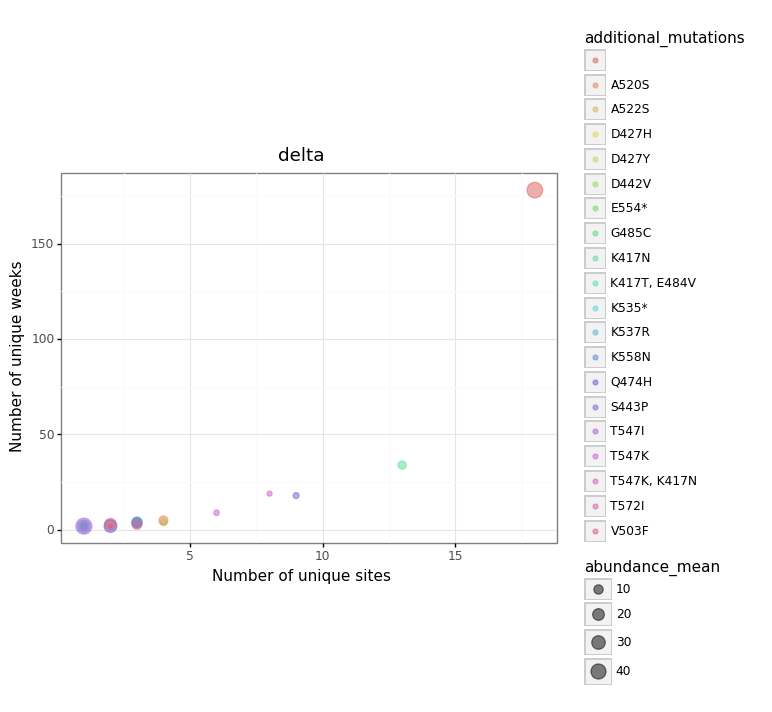

<ggplot: (317355626)>

In [305]:
(ggplot(rbd_filt_var_df[rbd_filt_var_df.sample_count > 1], aes(y='date_unique', x='location_unique', color='additional_mutations', size='abundance_mean'))+
geom_point(alpha = 0.5)+
theme_bw()+
ggtitle(var)+
ylab('Number of unique weeks')+
xlab('Number of unique sites')
)

## Search for lineages of interest

### Look for cryptic lineages

In [658]:
cryptic = abund_all_df[(abund_all_df.amplicon == 'RBD') & 
             #(abund_all_df.aa_substitution_count > 10) & 
             (abund_all_df.Abundance > 0) & 
             (abund_all_df.aaSubstitutions.str.contains('S:K417T'))][['Sample', 'sample_code', 'county', 'site_full_name', 
                                                                      'date_sampling', 'Sequence', 'Abundance', 
                                                                      'aaSubstitutions']].sort_values(['site_full_name', 'date_sampling']).copy()

cryptic = cryptic[cryptic.sample_code.isin(['I_I_INF', 'X_2_INF'])].groupby(['Sample', 'sample_code', 'county', 'site_full_name', 
                                                                      'date_sampling', 'Sequence', 'Abundance']).agg('sum').reset_index().copy()

cryptic['mutations'] = cryptic.aaSubstitutions.str.replace('S:','')
#cryptic = cryptic.rename(columns={'aaSubstitutions':'mutations'})

cryptic.mutations = cryptic.mutations.str.split(',')

In [659]:
import re
omicron_mutations = [
'K417N',
'N440K',
'G446S',
'S477N',
'T478K',
'E484A',
'Q493R',
'G496S',
'Q498R',
'N501Y',
'Y505H'
]

omicron_positions = []
for m in omicron_mutations:
    position = re.match(r'\w{1}(\d+)\w{1}', m).groups()[0]
    omicron_positions.append(position)

In [660]:
def split_mutations(df):
    '''
    Goes thru the dataframe provided by U Missouri and parses out individual mutations for each sequence, including amino acid changes.
    df must have a column called 'mutations' that is a list of mutations with amino acid changes in parentheses.
    Indels must be of format '###-insert' or ###-###Del '''
    
    pat = re.compile(r'((\w{1})(\d+)([\w\*]{1}))')

    records = []
    for row in df.itertuples():
        for m in row.mutations:
            r = pat.search(m).groups()
            mut_name = m
            wt = r[1]
            position = r[2]
            mut = r[3]

            record = [row.Sequence, mut_name, position, wt, mut, row.Sample, row.Abundance]
            records.append(record)

    df_long = pd.DataFrame.from_records(records, columns = ['seq_id', 'mutation_name', 'position', 'wildtype_aa', 'mutation_aa', 'sample_id', 'frequency'])
    df_long['wt_position'] = df_long.wildtype_aa + df_long.position
    
    return df_long

In [662]:
df_long = split_mutations(cryptic)

# add info about whether the mutation or mutated position are found in Omicron
# create new columns reporting whether the mutation is in omicron or the position is in omicron
df_long['Omicron Residues'] = 'Non-Omicron'
df_long.loc[df_long.position.isin(omicron_positions), 'Omicron Residues'] = 'Omicron Position'
df_long.loc[df_long.mutation_name.isin(omicron_mutations), 'Omicron Residues'] = 'Omicron Mutation'

# order the data by wildtype position for plotting nicely
sorting = df_long[['position', 'wt_position']].copy()
sorting.position = pd.to_numeric(sorting.position)
ordered_list = list(sorting.sort_values('position')['wt_position'].unique())
df_long.wt_position = pd.Categorical(df_long.wt_position, ordered=True, categories=ordered_list)

# aggregate by aaSubstitutions and flip to long format
df_abund = cryptic.groupby(['Sample', 'sample_code', 'county', 'site_full_name','date_sampling', 'Sequence', 'aaSubstitutions']).agg('sum').reset_index()
df_abund = df_abund[['county', 'sample_code', 'site_full_name','date_sampling', 'Sequence', 'Abundance']]

# merge abundance table to mutation table
df_long = df_long.merge(df_abund, left_on='seq_id', right_on='Sequence', how='left')

# sort by date for plotting
df_long = df_long.sort_values(['sample_code', 'date_sampling'])

In [672]:
# drop duplicates before plotting
df_long_tile_plot = df_long[['sample_code', 'wt_position', 'seq_id', 'Omicron Residues', 'mutation_aa']].drop_duplicates()

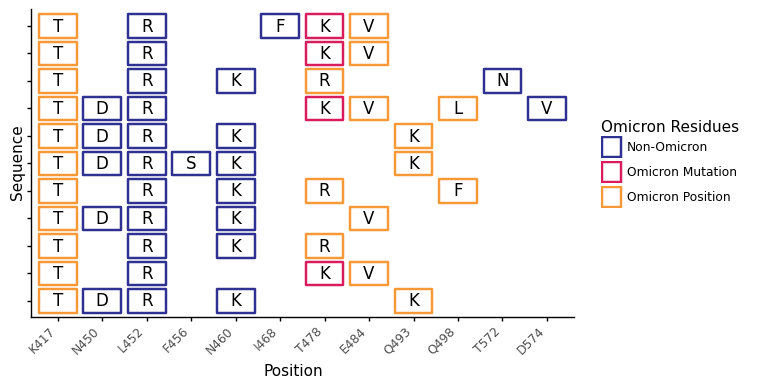

<ggplot: (317938547)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 4 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/figures/cryptic_lin2.svg


In [679]:
colors = ['#2e3192','#da1c5c', '#f89938']
plt = (ggplot(df_long_tile_plot[df_long_tile_plot.sample_code=='I_I_INF'], aes(x='wt_position', y='seq_id', color='Omicron Residues'))+ #X_2_INF
 geom_tile(aes(width=.85, height=.85), size=1, linetype='solid', fill='white')+
 geom_text(aes(label='mutation_aa'), color='black', size=12)+
 scale_color_manual(values=colors)+
 xlab('Position')+
 ylab('Sequence')+
 theme_classic()+
 theme(figure_size=(7,4), axis_text_x=element_text(angle=45, hjust=1), axis_text_y=element_blank()))

display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/figures/cryptic_lin2.svg')

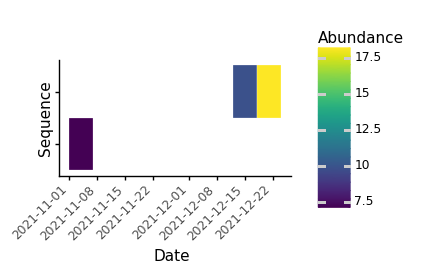

<ggplot: (318207859)>

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 1.5 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/figures/cryptic_lin_abund1.svg


In [712]:
df_abund = df_abund.sort_values(['sample_code', 'date_sampling'])
plt = (ggplot(df_abund[df_abund.sample_code=='X_2_INF'], aes(x='date_sampling', y='Sequence', fill='Abundance'))+
 geom_tile(color='white')+ # "white" adds gridlines here
 #scale_fill_brewer(palette='OrRd', type='seq')+ # can change the colors
 #scale_x_datetime(breaks='2 weeks')+
 xlab('Date')+
 ylab('Sequence')+
 #ylim(0,32)+
 theme_classic()+
 theme(figure_size=(3,1.5), axis_text_x=element_text(angle=45, hjust=1), axis_text_y=element_blank()))

display(plt)
ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/figures/cryptic_lin_abund1.svg')

In [707]:
df_abund[df_abund.sample_code=='I_I_INF'].dtypes

county                    object
sample_code               object
site_full_name            object
date_sampling     datetime64[ns]
Sequence                  object
Abundance                float64
dtype: object

## Find duplicate samples (extraction reps)
Decide what to do with these

In [22]:
# what happened to K_K_INF_111721_1?
rbd_raw = pd.read_csv(f'{results}/RBD_combined_dada2_out.csv')
seq_count = len(rbd_raw.columns)
seq_names = ['Seq'+str(x) for x in range(seq_count+1)][1:]
rbd_raw.columns = seq_names
    
k = rbd_raw[rbd_raw.index.isin(['K_K_INF_111721_1', 'K_K_INF_111721_2'])].copy()
k['Sample'] = k.index
k = k.melt(id_vars='Sample', var_name='Sequence', value_name='read_count')
k[k.read_count > 0].sort_values('Sample')

#rbd_raw[rbd_raw.index.str.startswith('K_K')]

# concerning because:
# rep 1 is dominated by Seq7
# rep 2 is dominated by Seq1
# is this a PCR error?

Sample Sequence  read_count
0    K_K_INF_111721_1     Seq1        1629
12   K_K_INF_111721_1     Seq7      256187
182  K_K_INF_111721_1    Seq92        6279
1    K_K_INF_111721_2     Seq1      184093

## Line plots by ASV

In [23]:
# could cluster on aaSubstitutions before making this plot, as above

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


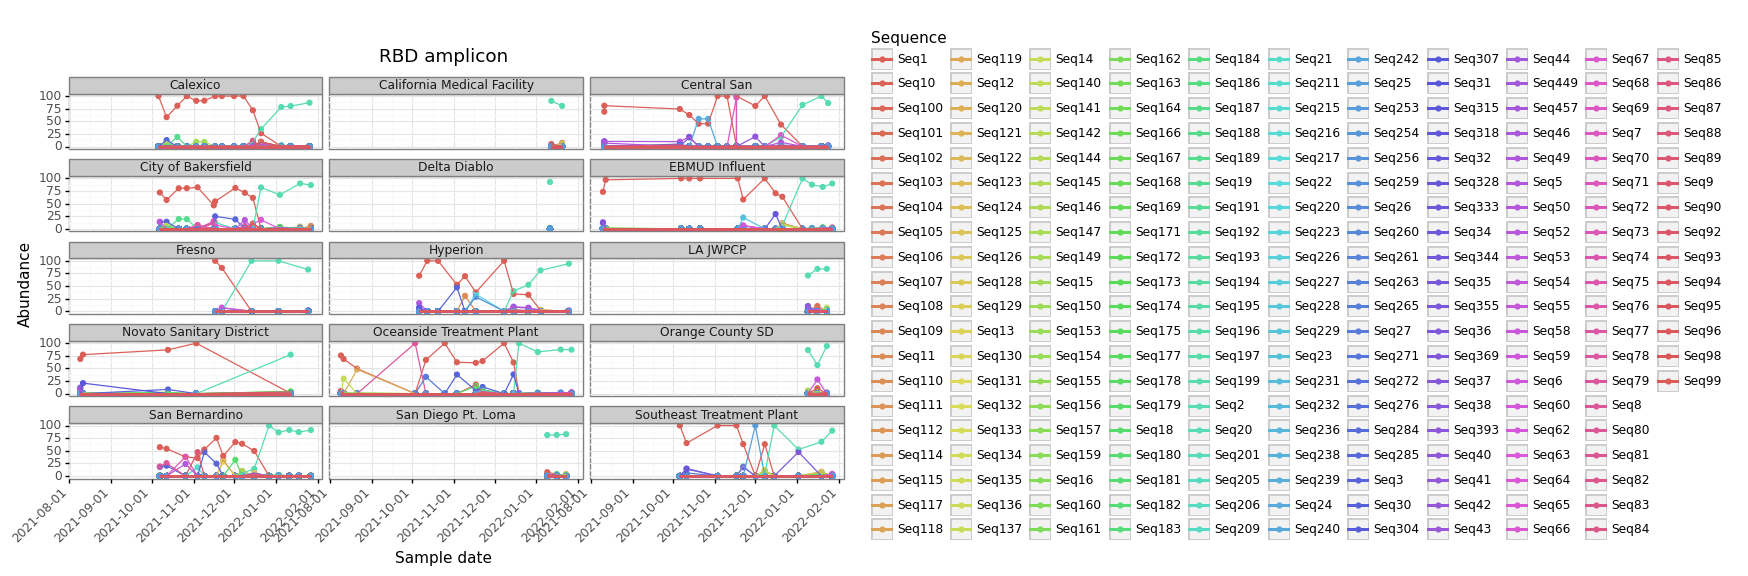

<ggplot: (364342257)>

In [24]:
(ggplot(abund_all_df[(abund_all_df.amplicon == 'RBD') &
                     ~(abund_all_df.site_full_name.isna())], 
        aes(y='Abundance', x='date_sampling', color='Sequence'))+
geom_point()+
geom_line()+
facet_wrap('~site_full_name', ncol=3)+
ggtitle(f'RBD amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


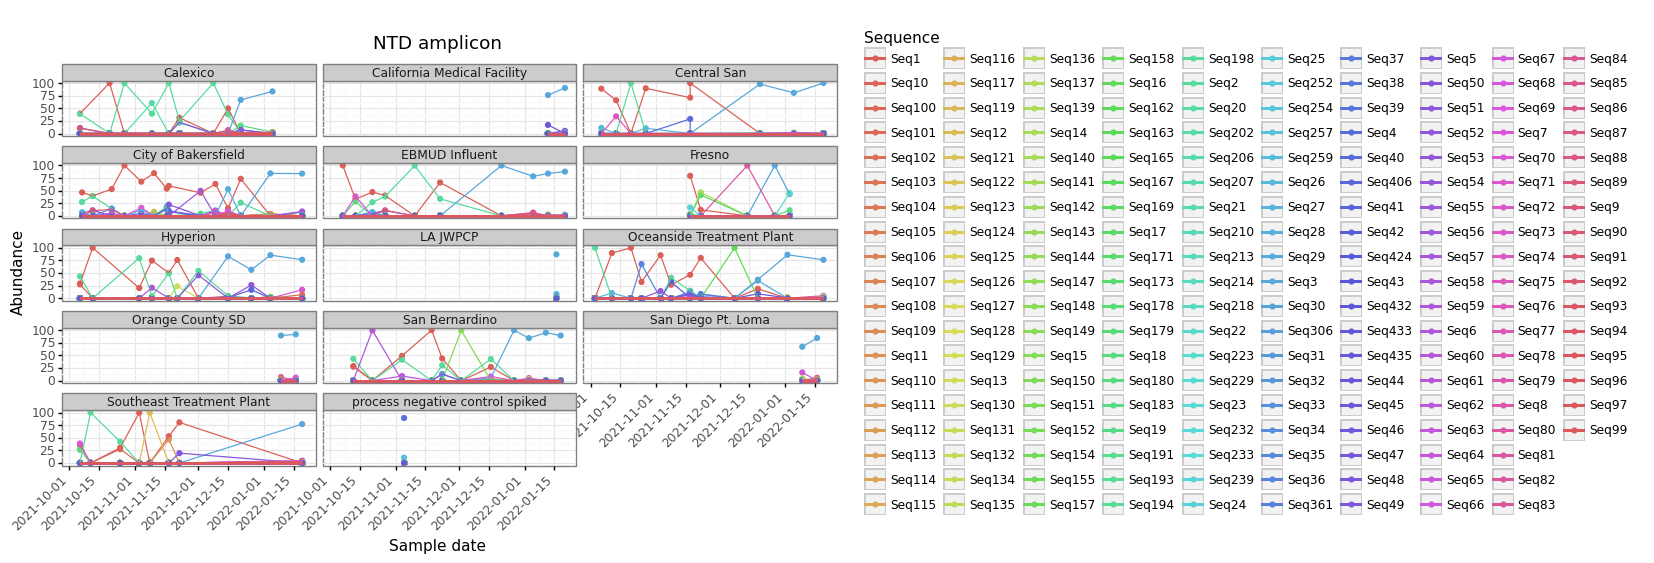

<ggplot: (378247156)>

In [158]:
(ggplot(abund_all_df[(abund_all_df.amplicon == 'NTD') &
                     ~(abund_all_df.site_full_name.isna()) &
                     ~(abund_all_df.site_full_name.isin(['Piedmont and Channing',
                                                         'City of American Canyon',
                                                         'Clark Kerr',
                                                         'City of Vacaville', 
                                                         'Las Gallinas Sanitary District',
                                                         'Novato Sanitary District',
                                                         'Delta Diablo']))], 
        aes(y='Abundance', x='date_sampling', color='Sequence'))+
geom_point()+
geom_line()+
facet_wrap('~site_full_name', ncol=3)+
ggtitle(f'NTD amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


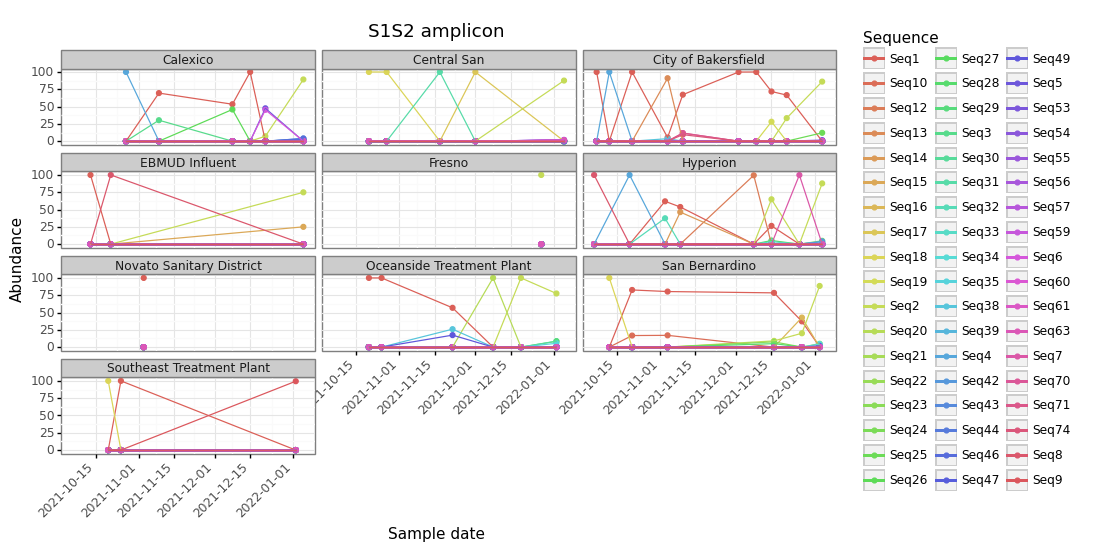

<ggplot: (387545872)>

In [159]:
(ggplot(abund_all_df[(abund_all_df.amplicon == 'S1S2') &
                     ~(abund_all_df.site_full_name.isna()) &
                     ~(abund_all_df.site_full_name.isin(['Piedmont and Channing',
                                                         'City of American Canyon',
                                                         'Clark Kerr',
                                                         'City of Vacaville', 
                                                         'Las Gallinas Sanitary District',
                                                         'Delta Diablo']))], 
        aes(y='Abundance', x='date_sampling', color='Sequence'))+
geom_point()+
geom_line()+
facet_wrap('~site_full_name', ncol=3)+
ggtitle(f'S1S2 amplicon')+
xlab('Sample date')+
#scale_y_log10()+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

## Heatmap by ASV

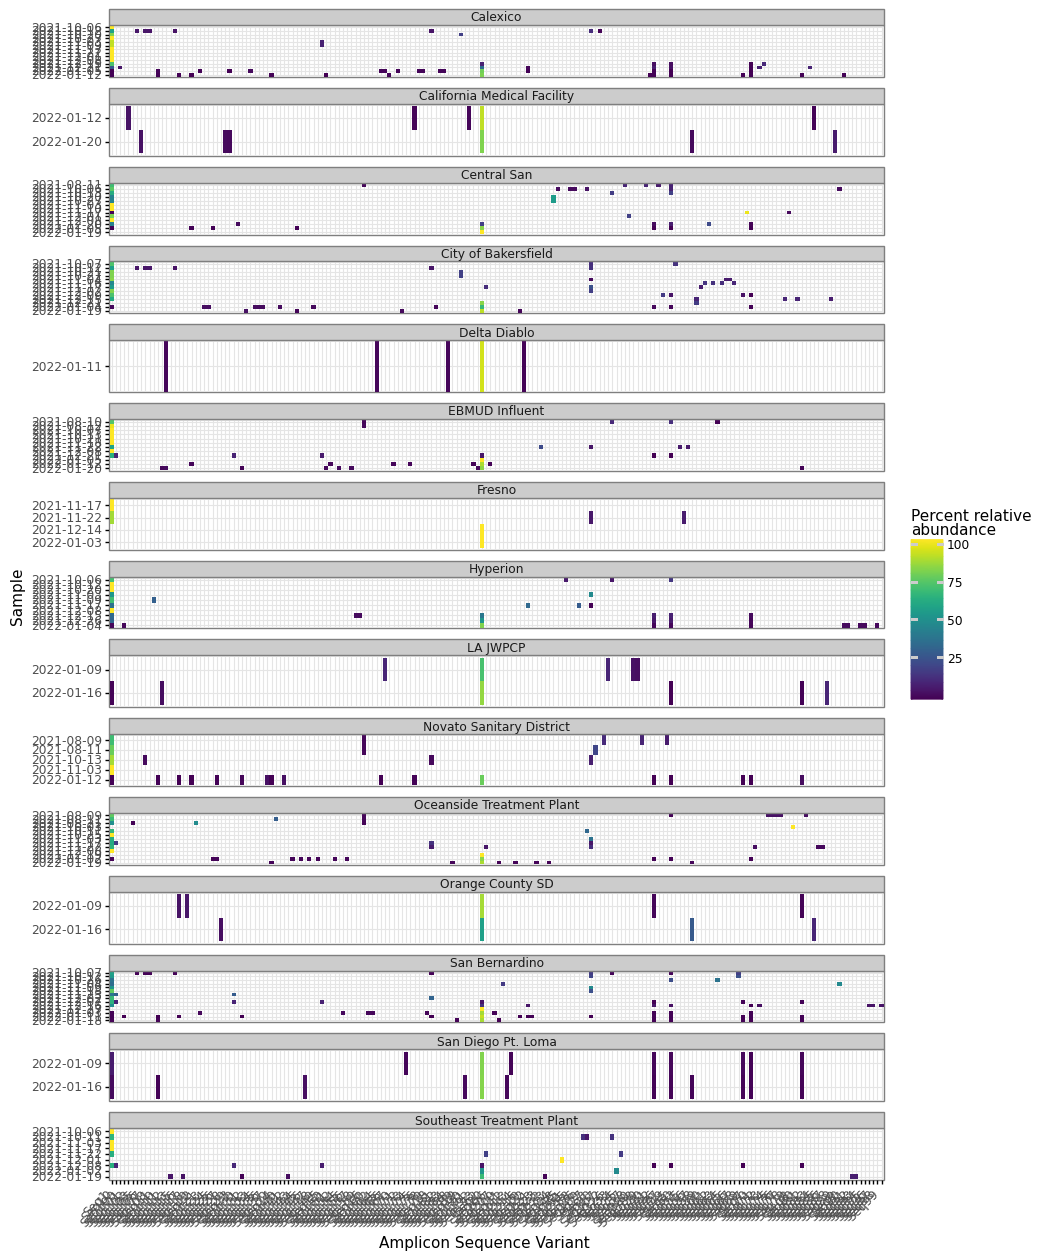

<ggplot: (358986725)>

In [161]:
abund_all_df['date'] = abund_all_df.date_sampling.dt.strftime(date_format='%Y-%m-%d')

df_plot = abund_all_df[(abund_all_df.amplicon == 'RBD') & (~abund_all_df.Sample.str.startswith('control'))].copy()
df_plot = df_plot[df_plot.Abundance > 0]
#df_plot.date_sampling = pd.Categorical(df_plot.date_sampling)
(ggplot(df_plot, aes(y='date', x='Sequence', fill='Abundance'))+
geom_tile()+
facet_wrap('~site_full_name', ncol=1, scales='free_y')+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Amplicon Sequence Variant')+
ylab('Sample')+
theme_bw()+
theme(figure_size=(10,15), axis_text_x=element_text(angle=45, hjust=1)))

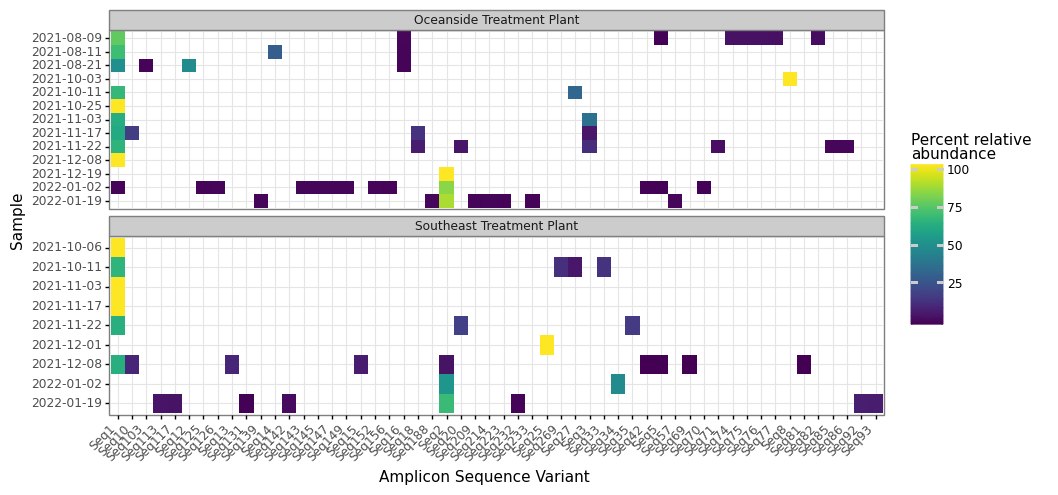

<ggplot: (378259188)>

In [162]:
abund_all_df['date'] = abund_all_df.date_sampling.dt.strftime(date_format='%Y-%m-%d')

df_plot = abund_all_df[(abund_all_df.amplicon == 'RBD') & (abund_all_df.Sample.str.startswith('D'))].copy()
df_plot = df_plot[df_plot.Abundance > 0]
#df_plot.date_sampling = pd.Categorical(df_plot.date_sampling)
(ggplot(df_plot, aes(y='date', x='Sequence', fill='Abundance'))+
geom_tile()+
facet_wrap('~site_full_name', ncol=1, scales='free_y')+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Amplicon Sequence Variant')+
ylab('Sample')+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

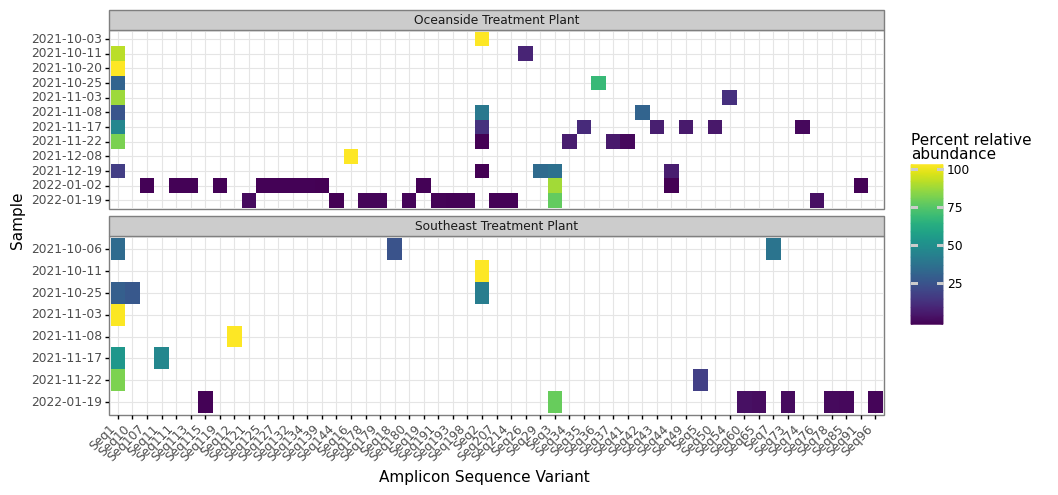

<ggplot: (358333425)>

In [163]:
abund_all_df['date'] = abund_all_df.date_sampling.dt.strftime(date_format='%Y-%m-%d')

df_plot = abund_all_df[(abund_all_df.amplicon == 'NTD') & (abund_all_df.Sample.str.startswith('D'))].copy()
df_plot = df_plot[df_plot.Abundance > 0]
#df_plot.date_sampling = pd.Categorical(df_plot.date_sampling)
(ggplot(df_plot, aes(y='date', x='Sequence', fill='Abundance'))+
geom_tile()+
facet_wrap('~site_full_name', ncol=1, scales='free_y')+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Amplicon Sequence Variant')+
ylab('Sample')+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

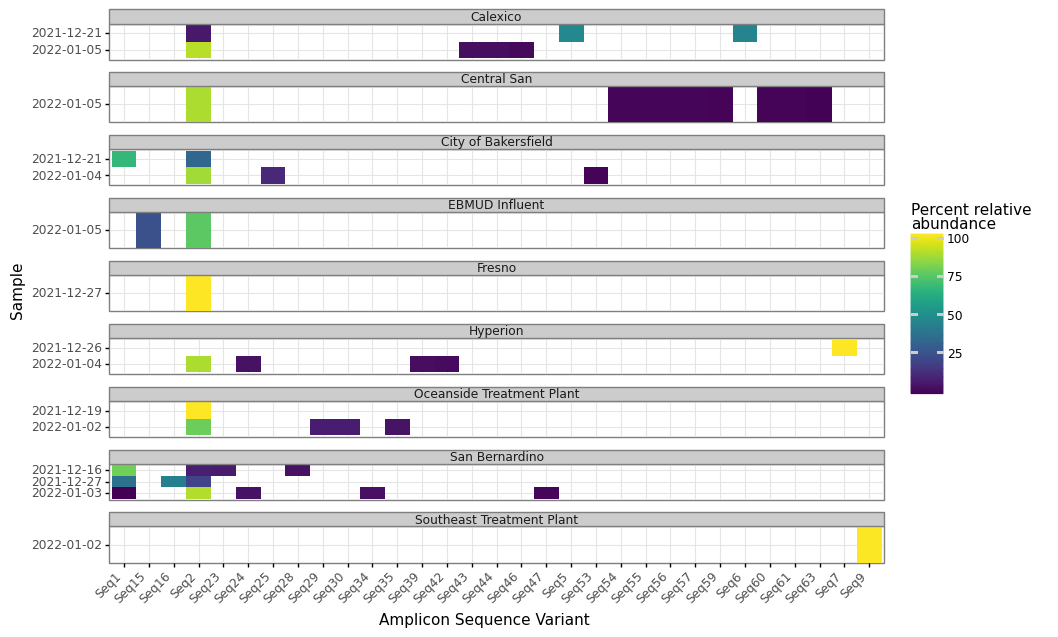

<ggplot: (358468184)>

In [164]:
df_plot = abund_all_df[(abund_all_df.amplicon == 'S1S2') &
                       (abund_all_df.date_sampling > '2021-12-15') &
                       (abund_all_df.Abundance > 0)
                      ].copy()
df_plot = df_plot[df_plot.Abundance > 0]
#df_plot.date_sampling = pd.Categorical(df_plot.date_sampling)
(ggplot(df_plot, aes(y='date', x='Sequence', fill='Abundance'))+
geom_tile()+
facet_wrap('~site_full_name', ncol=1, scales='free_y')+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Amplicon Sequence Variant')+
ylab('Sample')+
theme_bw()+
theme(figure_size=(10,7), axis_text_x=element_text(angle=45, hjust=1)))

# Find seqs in specific locations

## Marin

In [37]:
abund_all_df[(abund_all_df.county == 'Marin') & (abund_all_df.date_sampling > '2022-03-01')]#.date_sampling.unique()

Sample county            site_full_name date_sampling  \
171    B_B_INF_032722_4  Marin             CMSA influent    2022-03-27   
181    I_I_INF_032222_4  Marin  Novato Sanitary District    2022-03-22   
363    B_B_INF_032722_4  Marin             CMSA influent    2022-03-27   
373    I_I_INF_032222_4  Marin  Novato Sanitary District    2022-03-22   
555    B_B_INF_032722_4  Marin             CMSA influent    2022-03-27   
...                 ...    ...                       ...           ...   
49141  I_I_INF_032222_4  Marin  Novato Sanitary District    2022-03-22   
49323  B_B_INF_032722_4  Marin             CMSA influent    2022-03-27   
49333  I_I_INF_032222_4  Marin  Novato Sanitary District    2022-03-22   
49515  B_B_INF_032722_4  Marin             CMSA influent    2022-03-27   
49525  I_I_INF_032222_4  Marin  Novato Sanitary District    2022-03-22   

      sample_code Sequence  Abundance amplicon seqName        clade  \
171       B_B_INF     Seq1        0.0      RBD    Seq1  recombinant   
181       I_I_INF     Seq1        0.0      RBD    Seq1  recombinant   
363       B_B_INF     Seq2        0.0      RBD    Seq2  recombinant   
373       I_I_INF     Seq2        0.0      RBD    Seq2  recombinant   
555       B_B_INF     Seq3        0.0      RBD    Seq3  recombinant   
...           ...      ...        ...      ...     ...          ...   
49141     I_I_INF   Seq327        0.0      RBD  Seq327  recombinant   
49323     B_B_INF   Seq312        0.0      RBD  Seq312  recombinant   
49333     I_I_INF   Seq312        0.0      RBD  Seq312  recombinant   
49515     B_B_INF   Seq304        0.0      RBD  Seq304  recombinant   
49525     I_I_INF   Seq304        0.0      RBD  Seq304  recombinant   

                                           substitutions deletions insertions  \
171                                      T22917G,C22995A                        
181                                      T22917G,C22995A                        
363    G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
373    G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
555    G22813T,T22882G,G22992A,C22995A,A23013C,A23040...                        
...                                                  ...       ...        ...   
49141  G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
49323                            T22917G,C22938A,C22995A     22927              
49333                            T22917G,C22938A,C22995A     22927              
49515  G22813T,T22882G,G22898A,T22930C,G22992A,C22995...                        
49525  G22813T,T22882G,G22898A,T22930C,G22992A,C22995...                        

      frameShifts                                    aaSubstitutions  \
171                                                  S:L452R,S:T478K   
181                                                  S:L452R,S:T478K   
363                S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
373                S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
555                S:K417N,S:N440K,S:S477N,S:T478K,S:E484A,S:Q493...   
...           ...                                                ...   
49141              S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
49323  S:456-1274                                            S:L452R   
49333  S:456-1274                                            S:L452R   
49515              S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
49525              S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   

      aaDeletions  aa_substitution_count  
171                                    2  
181                                    2  
363                                   12  
373                                   12  
555                                    9  
...           ...                    ...  
49141                                 13  
49323     S:L455-                      1  
49333     S:L455-                      1  
49515  

## Bakersfield

In [21]:
bakersfield_seqs_df = abund_all_df[(abund_all_df.site_full_name == 'City of Bakersfield') &
             (abund_all_df.amplicon == 'RBD') &
             (abund_all_df.Abundance >= 5) &
             (abund_all_df.date_sampling >= '2021-11-01') &
             (abund_all_df.aa_substitution_count > 5)].sort_values(['date_sampling', 'Abundance']).copy()

In [25]:
bakersfield_seqs_df[bakersfield_seqs_df.aaSubstitutions.str.contains('K417T')]#.aaSubstitutions.values
bakersfield_seqs_df[bakersfield_seqs_df.aa_substitution_count > 10]



Sample county       site_full_name date_sampling sample_code  \
15437  X_2_INF_110421_1   Kern  City of Bakersfield    2021-11-04     X_2_INF   
6234   X_2_INF_121521_1   Kern  City of Bakersfield    2021-12-15     X_2_INF   
6235   X_2_INF_122121_1   Kern  City of Bakersfield    2021-12-21     X_2_INF   
187    X_2_INF_122121_1   Kern  City of Bakersfield    2021-12-21     X_2_INF   
185    X_2_INF_010422_1   Kern  City of Bakersfield    2022-01-04     X_2_INF   
221    X_2_INF_011922_1   Kern  City of Bakersfield    2022-01-19     X_2_INF   
17710  X_2_INF_012722_4   Kern  City of Bakersfield    2022-01-27     X_2_INF   
238    X_2_INF_012722_4   Kern  City of Bakersfield    2022-01-27     X_2_INF   
258    X_2_INF_020322_4   Kern  City of Bakersfield    2022-02-03     X_2_INF   
265    X_2_INF_030222_1   Kern  City of Bakersfield    2022-03-02     X_2_INF   

      Sequence  Abundance amplicon seqName         clade  \
15437    Seq92        7.4      RBD   Seq92   21I (Delta)   
6234     Seq76       10.0      RBD   Seq76  21G (Lambda)   
6235     Seq76       17.9      RBD   Seq76  21G (Lambda)   
187       Seq2       82.1      RBD    Seq2   recombinant   
185       Seq2       67.4      RBD    Seq2   recombinant   
221       Seq2       90.1      RBD    Seq2   recombinant   
17710   Seq126        5.9      RBD  Seq126   recombinant   
238       Seq2       86.8      RBD    Seq2   recombinant   
258       Seq2       95.9      RBD    Seq2   recombinant   
265       Seq2       99.7      RBD    Seq2   recombinant   

                                           substitutions deletions insertions  \
15437  A22812C,G22820A,T22896C,G22898A,C22916A,T22917...                        
6234   A22812C,G22820A,G22895C,T22896C,G22898A,C22916...                        
6235   A22812C,G22820A,G22895C,T22896C,G22898A,C22916...                        
187    G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
185    G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
221    G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
17710  G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
238    G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
258    G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        
265    G22813T,T22882G,G22898A,G22992A,C22995A,A23013...                        

      frameShifts                                    aaSubstitutions  \
15437              S:K417T,S:D420N,S:V445A,S:G446S,S:L452K,S:N460...   
6234               S:K417T,S:D420N,S:V445P,S:G446S,S:L452K,S:N460...   
6235               S:K417T,S:D420N,S:V445P,S:G446S,S:L452K,S:N460...   
187                S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
185                S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
221                S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
17710              S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
238                S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
258                S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   
265                S:K417N,S:N440K,S:G446S,S:S477N,S:T478K,S:E484...   

      aaDeletions  aa_substitution_count  
15437                                 16  
6234                                  16  
6235                                  16  
187                                   12  
185                                   12  
221                                   12  
17710                                 12  
238                                   12  
258                                   12  
265                                   12

In [45]:
abund_all_df.site_full_name.unique()

array(['EBMUD Influent', nan, 'Oceanside Treatment Plant',
       'Southeast Treatment Plant', 'Central San', 'Hyperion', 'Calexico',
       'San Bernardino', 'City of Bakersfield', 'Fresno',
       'Novato Sanitary District', 'Delta Diablo', 'LA JWPCP',
       'Orange County SD', 'California Medical Facility',
       'San Diego Pt. Loma', 'process negative control spiked'],
      dtype=object)

In [50]:
ocsd_seqs_df = abund_all_df[(abund_all_df.site_full_name == 'Orange County SD') &
             (abund_all_df.amplicon == 'RBD') &
             (abund_all_df.Abundance > 0) &
             (abund_all_df.date_sampling >= '2021-11-01') &
             (abund_all_df.aa_substitution_count > 5)].sort_values(['date_sampling', 'Abundance']).copy()

In [ ]:
# Orange County GISAID entry
# A879T, D215G, D614G, , H69del, I68del, I128V, 
# R408G, K417T, N460K, E484A, N501S
# L141F, L452R,
# L828F, L938F, M153T, ,, Q498Y, R357T, , S71del,
# S254F, T19K, T1076I, V70del, Y144del

In [52]:
ocsd_seqs_df[ocsd_seqs_df.aaSubstitutions.str.contains('N501S')]

Empty DataFrame
Columns: [Sample, county, site_full_name, date_sampling, sample_code, Sequence, Abundance, amplicon, seqName, clade, substitutions, deletions, insertions, frameShifts, aaSubstitutions, aaDeletions, aa_substitution_count]
Index: []

# Define variants by characteristic mutations

In [ ]:
# Dict from Devon Gregory
spike_variants_dict = {"Alpha": ['203-208Del(IHV68-70I--)', '429-431Del(VY143-144V-)', 'A1501T(N501Y)', 
                                  'C1709A(A570D)', 'A1841G(D614G)', 'C2042A(P681H)', 'C2147T(T716I)', 
                                  'T2944G(S982A)', 'G3352C(D1118H)'],
                    "Beta": ['A239C(D80A)', 'A644G(D215G)', '719-727Del(TLLA240-243T---)', 
                                     'G1251T(K417N)', 'G1450A(E484K)', 'A1501T(N501Y)', 'A1841G(D614G)', 
                                     'C2102T(A701V)'],
                    "Gamma": ['C52T(L18F)', 'C59A(T20N)', 'C76T(P26S)', 'G412T(D138Y)', 
                                     'G570T(R190S)', 'A1250C(K417T)', 'G1450A(E484K)', 'A1501T(N501Y)', 
                                     'A1841G(D614G)', 'C1963T(H655Y)', 'C3080T(T1027I)', 'G3526T(V1176F)'],
                    "Delta": ['C56G(T19R)', '467-472Del(EFR156-158G--)', 'T1355G(L452R)', 'C1433A(T478K)', 
                                     'A1841G(D614G)', 'C2042G(P681R)', 'G2848A(D950N)'],
                    "Omicron(BA.1)": ['C200T(A67V)', '203-208Del(IHV68-70I--)', 'C284T(T95I)', 
                                           '425-433Del(GVYY142-145D---)', '632-634Del(NL211-212I-)', 
                                           '643-insertGAGCCAGAA(215EPE)', 'G1016A(G339D)', 'TCC1111CTC(S371L)', 
                                           'T1117C(S373P)', 'C1124T(S375F)', 'G1251T(K417N)', 'T1320G(N440K)', 
                                           'G1430A(S477N)', 'C1433A(T478K)', 'A1451C(E484A)', 'A1478G(Q493R)', 
                                           'G1486A(G496S)', 'A1493G(Q498R)', 'A1501T(N501Y)', 'T1513C(Y505H)', 
                                           'C1640A(T547K)', 'A1841G(D614G)', 'C1963T(H655Y)', 'T2037G(N679K)', 
                                           'C2042A(P681H)', 'C2292A(N764K)', 'G2386T(D796Y)', 'C2568A(N856K)', 
                                           'A2862T(Q954H)', 'T2907A(N969K)', 'C2941T(L981F)'],
                    "Omicron(BA.2)": ['C56T(T19I)', '71-79Del(LPPA24-27S---)', 'G425A(G142D)', 'T638G(V213G)',
                                           'G1016A(G339D)', 'C1112T(S371F)', 'T1117C(S373P)', 'C1124T(S375F)', 
                                           'A1126G(T376A)', 'G1213A(D405N)', 'A1224C(R408S)', 'G1251T(K417N)', 
                                           'T1320G(N440K)', 'G1430A(S477N)', 'C1433A(T478K)', 'A1451C(E484A)', 
                                           'A1478G(Q493R)', 'A1493G(Q498R)', 'A1501T(N501Y)', 'T1513C(Y505H)', 
                                           'A1841G(D614G)', 'C1963T(H655Y)', 'T2037G(N679K)', 'C2042A(P681H)', 
                                           'C2292A(N764K)', 'G2386T(D796Y)', 'A2862T(Q954H)', 'T2907A(N969K)']
            }

# Make mutation frequency plots

In [167]:
nextclade_all_short_df[(nextclade_all_short_df.amplicon=='RBD') & (nextclade_all_short_df.frameShifts != '')].head()

amplicon seqName          clade  \
28      RBD   Seq29            20A   
38      RBD   Seq39            20A   
46      RBD   Seq47  21K (Omicron)   
67      RBD   Seq68            20A   
95      RBD   Seq96            20A   

                                        substitutions deletions insertions  \
28                            T22849G,T22917G,C22995A     22859              
38                            T22917G,C22995A,G23224C     23294              
46  G22813T,T22882G,G22898A,G22992A,C22995A,A23013...              22927:T   
67                            T22917G,C22995A,A23172G     23204              
95                            T22917G,G22923T,C22995A     22808              

   frameShifts          aaSubstitutions aaDeletions  aa_substitution_count  
28  S:433-1274                  S:F429L                                  7  
38  S:578-1274  S:L452R,S:T478K,S:E554D                                 23  
46  S:456-1274  S:K417N,S:N440K,S:G446S                                 23  
67  S:548-1274  S:L452R,S:T478K,S:K537R                                 23  
95  S:416-1274                                                           0

In [170]:
mutations_df = []
for r in nextclade_all_short_df[nextclade_all_short_df.amplicon == 'RBD'].itertuples():
    snvs = r.aaSubstitutions.split(',')
    for snv in snvs:
        mutations_df.append([r.seqName, snv])
mutations_df = pd.DataFrame.from_records(mutations_df, columns=['Sequence', 'mutation'])

mutation_freq_df = abund_all_df[abund_all_df.amplicon=='RBD'].merge(mutations_df, on='Sequence')

In [172]:
mutation_freq_df = mutation_freq_df.groupby(['Sample', 'county', 'site_full_name',
                          'date_sampling', 'mutation']).agg('sum').reset_index()

In [173]:
mutation_summary_df = mutation_freq_df.groupby('mutation').agg('max').reset_index()[['mutation', 'Abundance']]
mutation_summary_df = mutation_summary_df.sort_values('Abundance', ascending=False)
mutation_list = mutation_summary_df[mutation_summary_df.Abundance > 7]['mutation'].to_list()

In [174]:
mutation_freq_df = mutation_freq_df[mutation_freq_df.mutation.isin(mutation_list)].copy()
mutation_freq_df.mutation = pd.Categorical(mutation_freq_df.mutation, ordered=True, categories=mutation_list)

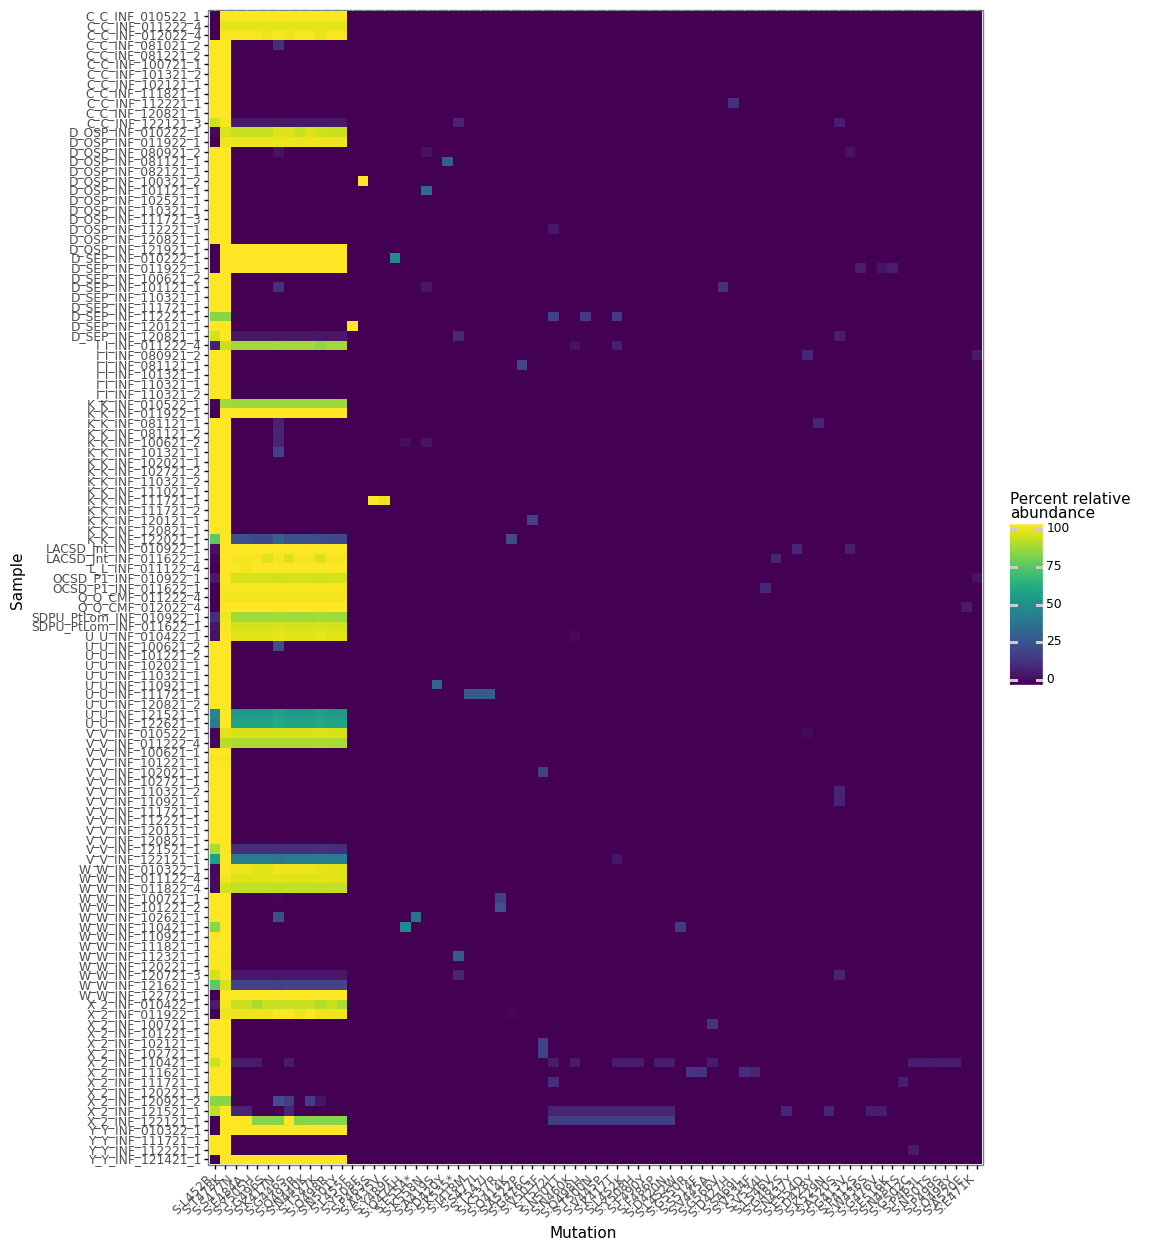

<ggplot: (378738420)>

In [176]:
(ggplot(mutation_freq_df, aes(y='Sample', x='mutation', fill='Abundance'))+
geom_tile()+
#facet_wrap('~site_full_name', ncol=1)+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Mutation')+
ylab('Sample')+
theme_bw()+
theme(figure_size=(10,15), axis_text_x=element_text(angle=45, hjust=1)))

In [177]:
mutation_freq_df.loc[mutation_freq_df.Abundance == 0, 'Abundance'] = np.nan
mutation_freq_df = mutation_freq_df.dropna().copy()

In [178]:
mutation_freq_df['date'] = mutation_freq_df.date_sampling.dt.strftime(date_format='%Y-%m-%d')

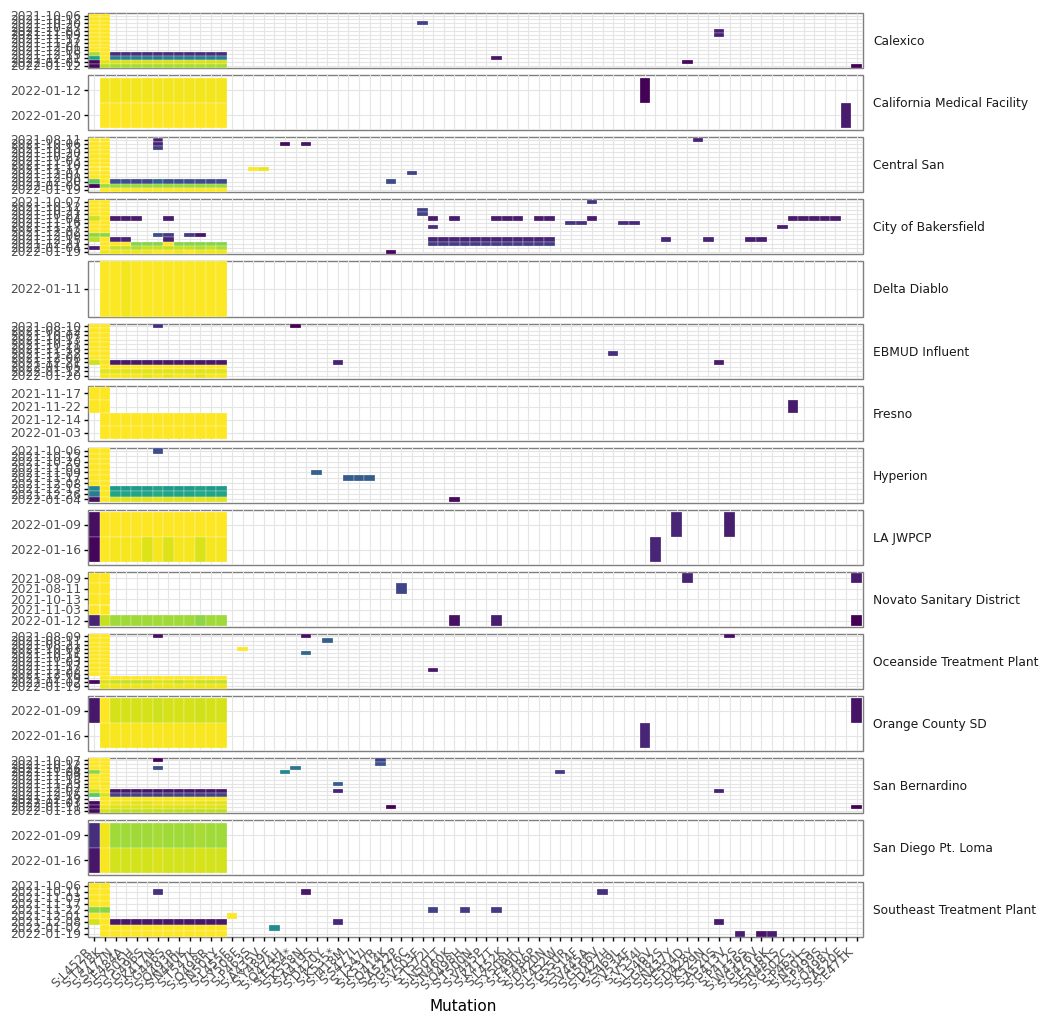

<ggplot: (677318635)>

In [179]:
# copy of below:

(ggplot(mutation_freq_df, aes(y='date', x='mutation', fill='Abundance'))+
geom_tile(color='white')+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Mutation')+
ylab('')+
coord_trans(y='reverse')+ # reverse the y axis
facet_grid('site_full_name~', scales='free_y')+
theme_bw()+
theme(figure_size=(10,12), axis_text_x=element_text(angle=45, hjust=1),
     strip_text_y = element_text(angle = 0, ha = 'left'),
     strip_background_y=element_blank(),
     legend_position='none'))


In [180]:
mutation_freq_df[mutation_freq_df.site_full_name == 'City of Bakersfield'].head()

Sample county       site_full_name date_sampling mutation  \
13894  X_2_INF_010422_1   Kern  City of Bakersfield    2022-01-04  S:E484A   
13907  X_2_INF_010422_1   Kern  City of Bakersfield    2022-01-04  S:G446S   
13916  X_2_INF_010422_1   Kern  City of Bakersfield    2022-01-04  S:G496S   
13931  X_2_INF_010422_1   Kern  City of Bakersfield    2022-01-04  S:K417N   
13941  X_2_INF_010422_1   Kern  City of Bakersfield    2022-01-04  S:L452R   

       Abundance        date  
13894       91.5  2022-01-04  
13907       91.5  2022-01-04  
13916       91.5  2022-01-04  
13931       91.3  2022-01-04  
13941        7.7  2022-01-04

In [181]:
mutation_freq_bakersfield = mutation_freq_df[mutation_freq_df.site_full_name == 'City of Bakersfield'].copy()
mutation_freq_bakersfield.loc[mutation_freq_bakersfield.Abundance.isna(), 'Abundance'] = 0

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 3 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/bakersfield_mutation_heatmap.png


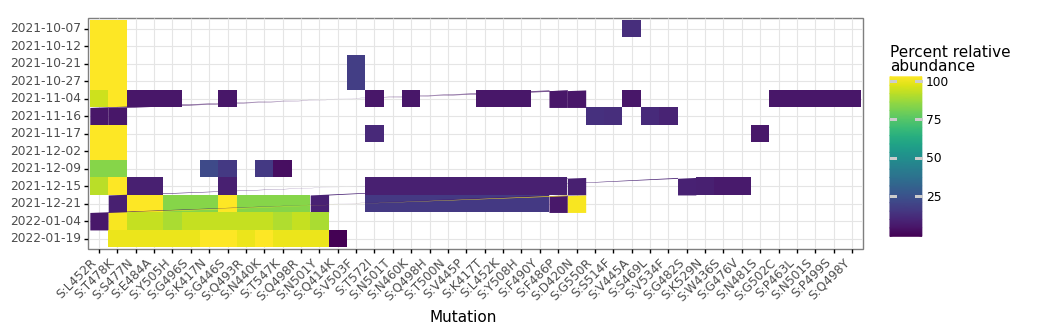

<ggplot: (678891156)>

In [182]:
plt = (ggplot(mutation_freq_bakersfield, aes(y='date', x='mutation', fill='Abundance'))+
geom_tile()+ #color='white'
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
#scale_fill_continuous()+
xlab('Mutation')+
ylab('')+
coord_trans(y='reverse')+ # reverse the y axis
#facet_grid('site_full_name~', scales='free_y')+
theme_bw()+
theme(figure_size=(10,3), axis_text_x=element_text(angle=45, hjust=1)#,
     #strip_text_y = element_text(angle = 0, ha = 'left'),
     #strip_background_y=element_blank(),
     #legend_position='none'
     ))
ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/bakersfield_mutation_heatmap.png')
plt

# UNAM analysis

In [213]:
# non-UNAM samples from the same batch:
nonunam_samples = ['2101089', '9181_1', '9185_3', '9194_2',
       'D_OSP_INF_042521_1', 'D_OSP_INF_060621_1', 'D_OSP_INF_062721_1',
       'D_SEP_INF_071121_1', 'OCSD_071221_2', 'C_C_INF_060821_1', 'control_control_Twist_040922_1',
       'D_OSP_INF_052321_1', 'I_I_INF_071321_1', 'K_K_INF_050221_1',
       'OCSD_030121_1', 'OCSD_042621_1']

nonunam = abund_all_df [abund_all_df.Sample.isin(nonunam_samples)].copy()
unam = abund_all_df[abund_all_df.Sample.str.contains('UNAM')].copy()
batch110222 = pd.concat([unam, nonunam])
batch110222 = batch110222[batch110222.Abundance>0][['amplicon', 'Sample', 'Sequence', 'Abundance', 'clade', 
      'substitutions', 'deletions', 'insertions', 'frameShifts', 
      'aaSubstitutions', 'aaDeletions', 'aa_substitution_count']]

# add names from UNAM sheet
names_lookup = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/unam_names_lookup.csv')
names_lookup.date = pd.to_datetime(names_lookup.date)
names_lookup['name'] = names_lookup.date.dt.strftime('%d/%m/%Y')
names_lookup['name'] = names_lookup.name + "_UNAM"
batch110222 = batch110222.merge(names_lookup, how='left', on='Sample')
batch110222.loc[batch110222.name.isna(), 'name'] = batch110222.Sample
batch110222.loc[batch110222.Sample=='UNAM_26', 'name'] = '2.031 wet'
batch110222.loc[batch110222.Sample=='UNAM_29', 'name'] = 'positive_control'

In [215]:
batch110222[batch110222.amplicon=='NTD'].name.unique()

array(['10/01/2022_UNAM', '17/01/2022_UNAM', '20/01/2022_UNAM',
       '24/01/2022_UNAM', '10/02/2022_UNAM', '14/02/2022_UNAM',
       '17/02/2022_UNAM', 'positive_control', '25/08/2021_UNAM',
       '10/09/2021_UNAM', '20/05/2021_UNAM', '13/05/2021_UNAM'],
      dtype=object)

In [216]:
order=['2.031 wet', '13/05/2021_UNAM', '20/05/2021_UNAM', '25/08/2021_UNAM','10/09/2021_UNAM', '30/11/2021_UNAM',  
        '10/01/2022_UNAM', '17/01/2022_UNAM', '20/01/2022_UNAM', '24/01/2022_UNAM',
       '03/02/2022_UNAM', '10/02/2022_UNAM', '14/02/2022_UNAM', '17/02/2022_UNAM', 
       '9181_1', '9185_3', 'C_C_INF_060821_1',
       'D_OSP_INF_060621_1', 
       'D_SEP_INF_071121_1', 'positive_control']

batch110222['name'] = pd.Categorical(batch110222.name, categories = order, ordered=True)

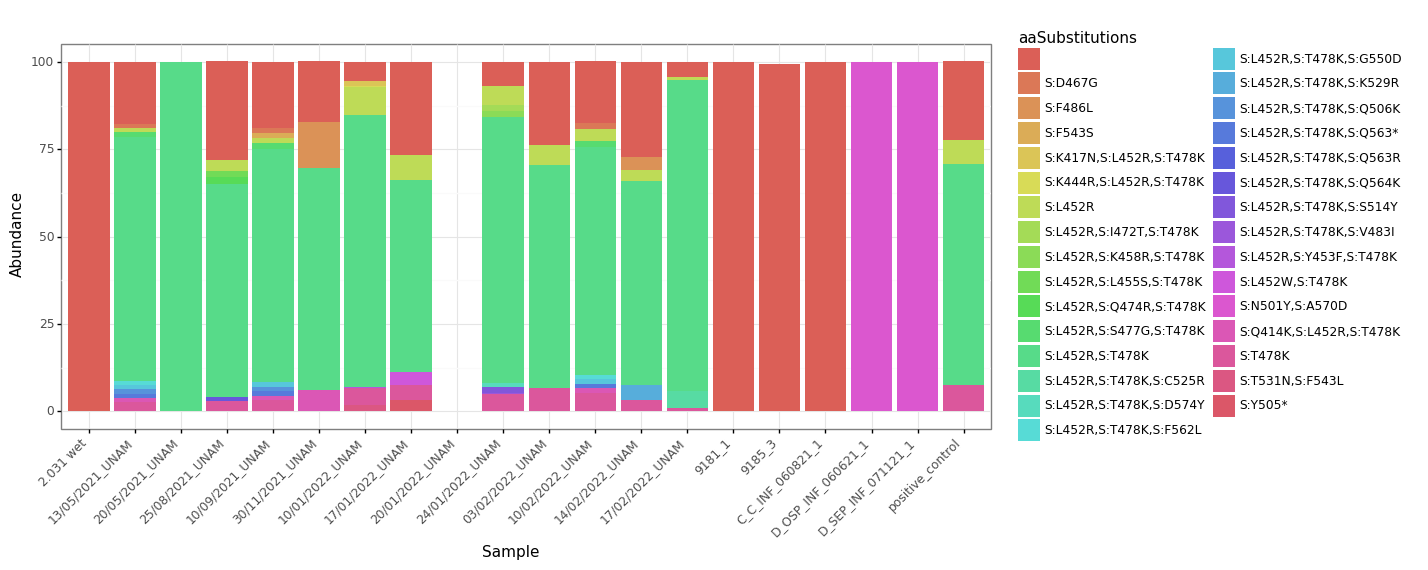

<ggplot: (379221221)>

In [217]:
batch110222_rbd = batch110222[batch110222.amplicon == 'RBD'].groupby(['aaSubstitutions', 'Sample', 'name']).sum().reset_index().copy()

(ggplot(batch110222_rbd, aes(x='name', y='Abundance', fill='aaSubstitutions'))+
geom_bar(stat='identity')+
xlab('Sample')+
theme_bw()+
theme(figure_size=(12,5), axis_text_x=element_text(angle=45, hjust=1)))

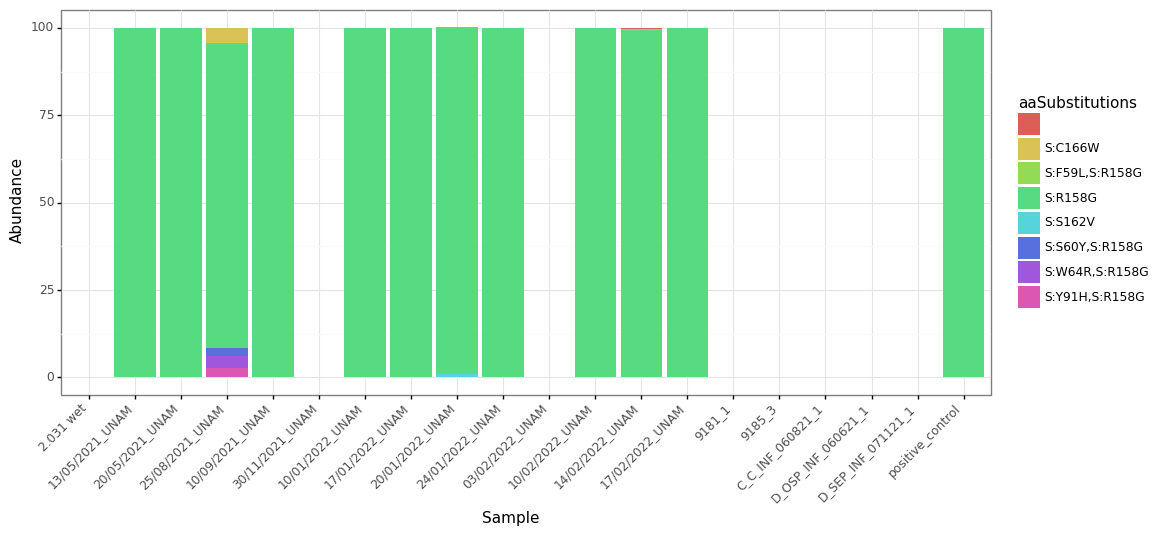

<ggplot: (371213740)>

In [218]:
batch110222_ntd = batch110222[batch110222.amplicon == 'NTD'].groupby(['aaSubstitutions', 'Sample', 'name']).sum().reset_index().copy()

(ggplot(batch110222_ntd, aes(x='name', y='Abundance', fill='aaSubstitutions'))+
geom_bar(stat='identity')+
#ggtitle('Cerro de la Estrella RBD amplicon')+
xlab('Sample')+
theme_bw()+
theme(figure_size=(12,5), axis_text_x=element_text(angle=45, hjust=1)))

In [65]:
unam = abund_all_df[abund_all_df.Sample.str.contains('UNAM') & abund_all_df.Abundance > 0].copy()

unam = unam[['amplicon', 'Sample', 'Sequence', 'Abundance', 'clade', 
      'substitutions', 'deletions', 'insertions', 'frameShifts', 
      'aaSubstitutions', 'aaDeletions', 'aa_substitution_count']].copy()

unam

amplicon   Sample Sequence  Abundance        clade    substitutions  \
121         RBD  UNAM_10     Seq1       78.0  recombinant  T22917G,C22995A   
122         RBD  UNAM_12     Seq1       54.8  recombinant  T22917G,C22995A   
123         RBD  UNAM_14     Seq1       68.3  recombinant  T22917G,C22995A   
124         RBD  UNAM_15     Seq1       63.7  recombinant  T22917G,C22995A   
125         RBD  UNAM_16     Seq1       64.0  recombinant  T22917G,C22995A   
...         ...      ...      ...        ...          ...              ...   
148427      NTD   UNAM_3   Seq322        3.4          20D  T21751C,T21752A   
150737      NTD   UNAM_3   Seq341        2.7          19A          T21833C   
154202      NTD   UNAM_3   Seq348        2.3          19A          C21741A   
164261      NTD  UNAM_13   Seq452        1.1          19A  A22046G,G22047T   
187199      NTD  UNAM_17   Seq441        0.2          19A                    

          deletions insertions frameShifts  aaSubstitutions      aaDeletions  \
121                                         S:L452R,S:T478K                    
122                                         S:L452R,S:T478K                    
123                                         S:L452R,S:T478K                    
124                                         S:L452R,S:T478K                    
125                                         S:L452R,S:T478K                    
...             ...        ...         ...              ...              ...   
148427  22029-22034                          S:W64R,S:R158G  S:E156-,S:F157-   
150737  22029-22034                          S:Y91H,S:R158G  S:E156-,S:F157-   
154202  22029-22034                          S:S60Y,S:R158G  S:E156-,S:F157-   
164261                                              S:S162V                    
187199  22208-22213                                          S:L216-,S:P217-   

        aa_substitution_count  
121                         2  
122                         2  
123                         2  
124                         2  
125                         2  
...                       ...  
148427                      2  
150737                      2  
154202                      2  
164261                      1  
187199                      1  

[137 rows x 12 columns]

In [138]:
unam[unam.amplicon=='RBD'].Sample.unique()

array(['UNAM-UC 47', 'UNAM-UC 49', 'UNAM-UC 51', 'UNAM-UC 52',
       'UNAM-UC 53', 'UNAM-UC 54', 'UNAM-UC 55', 'pos-control',
       'UNAM-UC 12', 'UNAM-UC 13', 'UNAM-UC 39', 'UNAM-UC 45',
       'UNAM-UC 46', '2.031 wet'], dtype=object)

In [147]:
names_lookup = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/unam_names_lookup.csv')

sample_id  Sample       date                  site        name
0   UNAM-UC 1  UNAM_1 2021-07-12  Cerro de la Estrella  12/07/2021
1   UNAM-UC 3  UNAM_2 2021-08-14  Cerro de la Estrella  14/08/2021
2  UNAM-UC 12  UNAM_3 2021-08-25  Cerro de la Estrella  25/08/2021
3  UNAM-UC 13  UNAM_4 2021-09-10  Cerro de la Estrella  10/09/2021
4  UNAM-UC 14  UNAM_5 2021-09-07  Cerro de la Estrella  07/09/2021

In [67]:
unam = unam.merge(names_lookup)
unam = unam.drop(columns='Sample')
unam = unam.rename(columns={'sample_id':'Sample'})

# need to drop Sample, change to sample_id before next cell

In [75]:
unam.date = pd.to_datetime(unam.date)
unam.head()

amplicon Sequence  Abundance        clade            substitutions  \
0      RBD     Seq1       78.0  recombinant          T22917G,C22995A   
1      RBD     Seq4        5.5          19A                            
2      RBD     Seq7        1.4  21I (Delta)  G22813T,T22917G,C22995A   
3      RBD    Seq57        8.0          19B                  T22917G   
4      RBD    Seq61        4.9          20B                  C22995A   

  deletions insertions frameShifts          aaSubstitutions aaDeletions  \
0                                           S:L452R,S:T478K               
1                                                                         
2                                   S:K417N,S:L452R,S:T478K               
3                                                   S:L452R               
4                                                   S:T478K               

   aa_substitution_count      Sample       date                  site  
0                      2  UNAM-UC 47 2022-01-10  Cerro de la Estrella  
1                      1  UNAM-UC 47 2022-01-10  Cerro de la Estrella  
2                      3  UNAM-UC 47 2022-01-10  Cerro de la Estrella  
3                      1  UNAM-UC 47 2022-01-10  Cerro de la Estrella  
4                      1  UNAM-UC 47 2022-01-10  Cerro de la Estrella

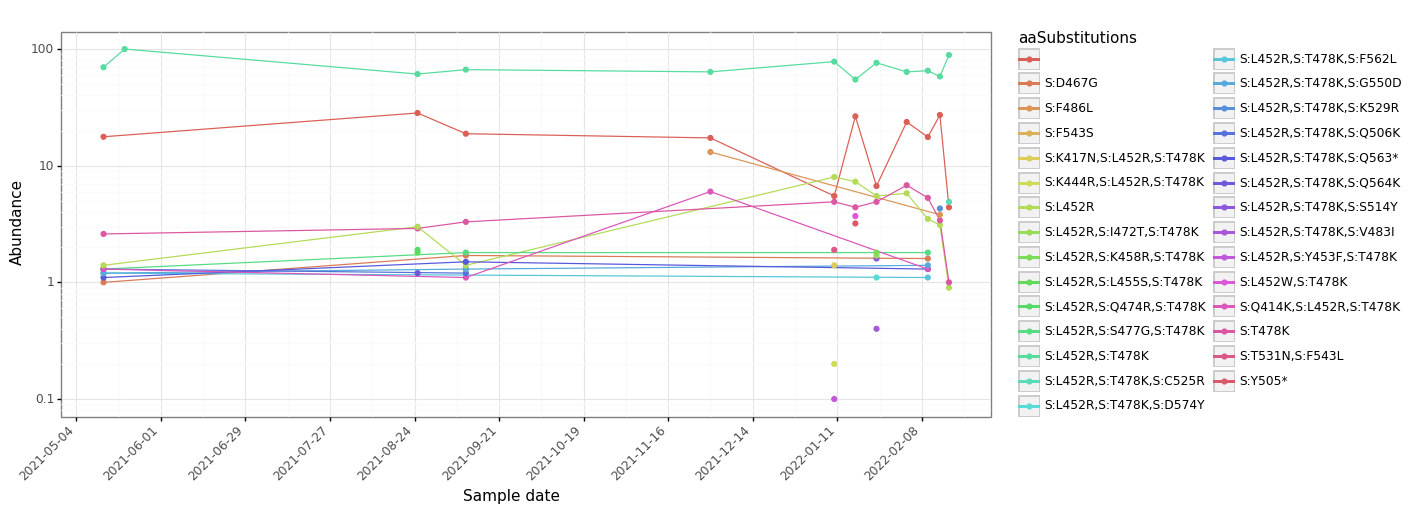

<ggplot: (374592976)>

In [104]:
unam_aasub = unam[unam.amplicon == 'RBD'].groupby(['aaSubstitutions', 'Sample', 'date', 'site']).sum().reset_index().sort_values(['date', 'Abundance']).copy()
unam_aasub = unam_aasub[unam_aasub.site == 'Cerro de la Estrella'].copy()

plt = (ggplot(unam_aasub, 
        aes(y='Abundance', x='date', color='aaSubstitutions'))+
geom_line()+
geom_point()+
#scale_color_manual(values=colors)+
scale_x_datetime(breaks = '4 weeks')+
#ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
scale_y_log10()+
theme_bw()+
#theme(subplots_adjust={'wspace': 0.05})+
theme(figure_size=(12,5), axis_text_x=element_text(angle=45, hjust=1)))

display(plt)


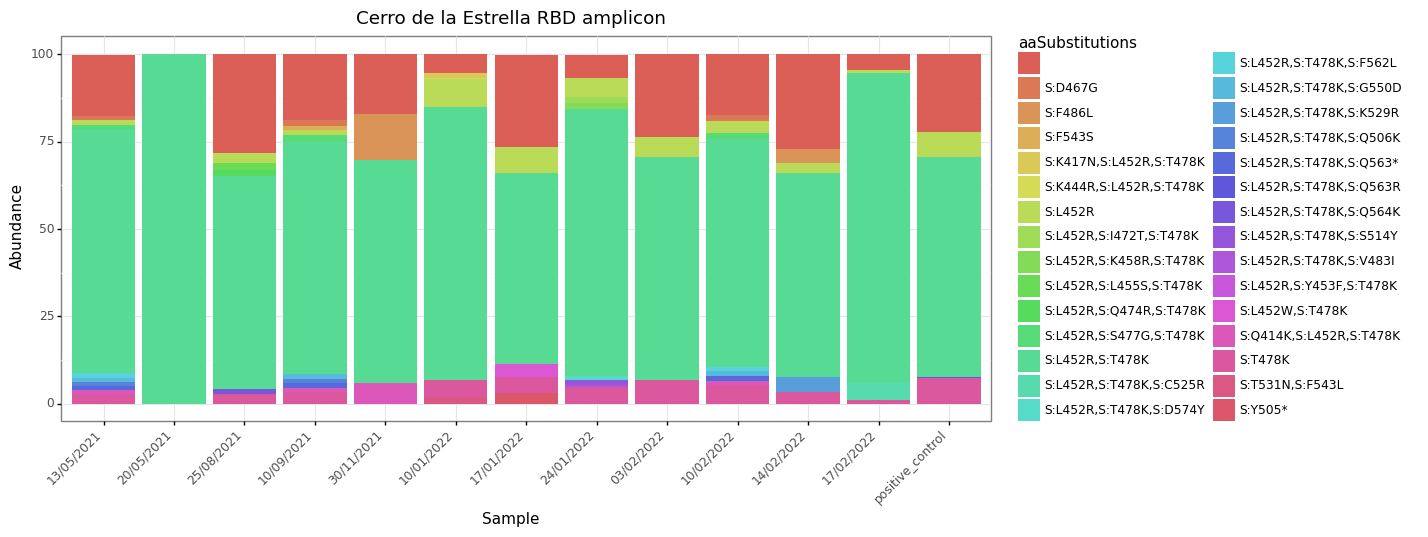

<ggplot: (375586723)>

In [133]:
unam_aasub = unam[unam.amplicon == 'RBD'].groupby(['aaSubstitutions', 'Sample', 'date', 'site']).sum().reset_index().sort_values(['date', 'Abundance']).copy()
unam_aasub = unam_aasub[unam_aasub.site == 'Cerro de la Estrella'].copy()
unam_aasub['name'] = unam_aasub.date.dt.strftime('%d/%m/%Y')

pos = unam[(unam.Sample == 'pos-control') & (unam.amplicon == 'RBD')].copy()
pos = pos.groupby(['aaSubstitutions']).sum().reset_index().copy()
pos['name'] = 'positive_control'
unam_pos_aasub = pd.concat([pos, unam_aasub])
order = unam_pos_aasub.sort_values('date')['name'].unique()

unam_pos_aasub.name = pd.Categorical(unam_pos_aasub.name, categories=order)

(ggplot(unam_pos_aasub, aes(x='name', y='Abundance', fill='aaSubstitutions'))+
geom_bar(stat='identity')+
ggtitle('Cerro de la Estrella RBD amplicon')+
xlab('Sample')+
theme_bw()+
theme(figure_size=(12,5), axis_text_x=element_text(angle=45, hjust=1)))

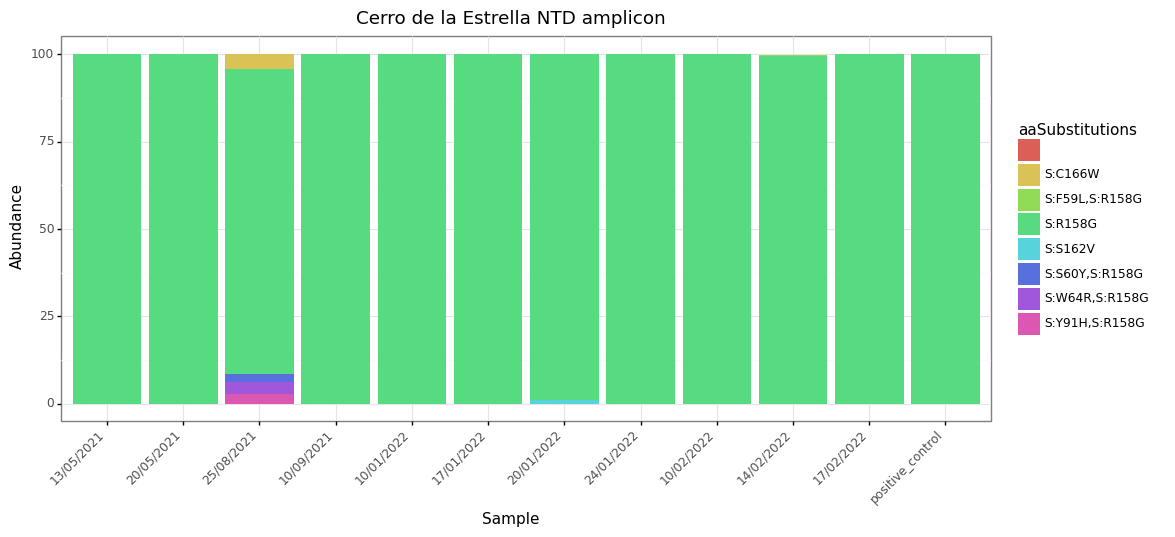

<ggplot: (375331094)>

In [132]:
unam_aasub = unam[unam.amplicon == 'NTD'].groupby(['aaSubstitutions', 'Sample', 'date', 'site']).sum().reset_index().sort_values(['date', 'Abundance']).copy()
unam_aasub = unam_aasub[unam_aasub.site == 'Cerro de la Estrella'].copy()
unam_aasub['name'] = unam_aasub.date.dt.strftime('%d/%m/%Y')

pos = unam[(unam.Sample == 'pos-control') & (unam.amplicon == 'NTD')].copy()
pos = pos.groupby(['aaSubstitutions']).sum().reset_index().copy()
pos['name'] = 'positive_control'
unam_pos_aasub = pd.concat([pos, unam_aasub])
order = unam_pos_aasub.sort_values('date')['name'].unique()

unam_pos_aasub.name = pd.Categorical(unam_pos_aasub.name, categories=order)

(ggplot(unam_pos_aasub, aes(x='name', y='Abundance', fill='aaSubstitutions'))+
geom_bar(stat='identity')+
ggtitle('Cerro de la Estrella NTD amplicon')+
xlab('Sample')+
theme_bw()+
theme(figure_size=(12,5), axis_text_x=element_text(angle=45, hjust=1)))

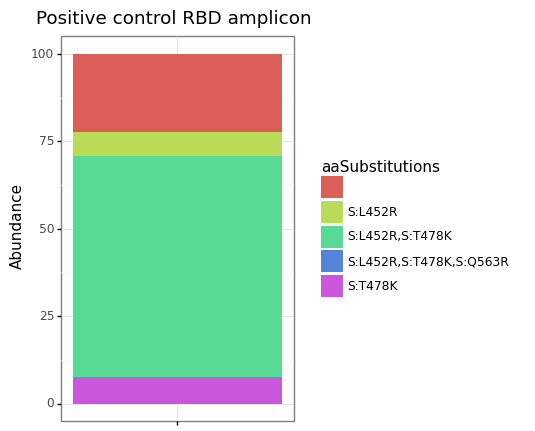

<ggplot: (374735406)>

In [137]:
(ggplot(unam_pos_aasub[unam_pos_aasub.name=='positive_control'], aes(x='name', y='Abundance', fill='aaSubstitutions'))+
geom_bar(stat='identity')+
ggtitle('Positive control RBD amplicon')+
xlab('')+
theme_bw()+
theme(figure_size=(3,5), axis_text_x=element_blank()))

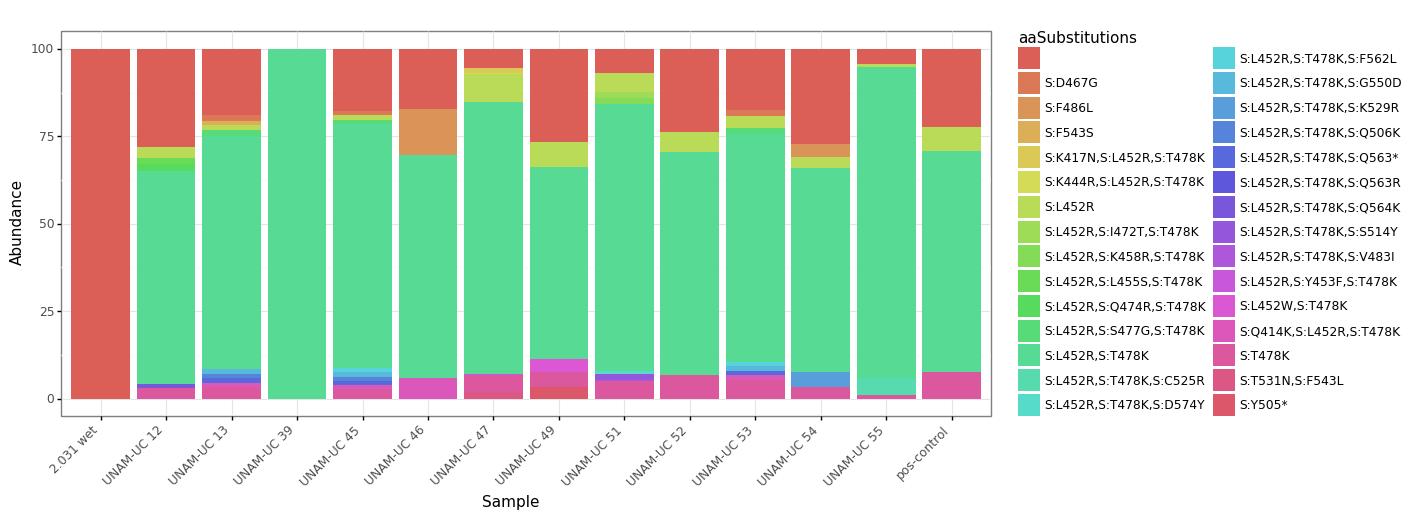

<ggplot: (377779309)>

In [135]:
unam_aasub_all = unam[unam.amplicon == 'RBD'].groupby(['aaSubstitutions', 'Sample']).sum().reset_index().copy()

(ggplot(unam_aasub_all, aes(x='Sample', y='Abundance', fill='aaSubstitutions'))+
geom_bar(stat='identity')+
theme_bw()+
theme(figure_size=(12,5), axis_text_x=element_text(angle=45, hjust=1)))

In [97]:
# Classify based on the manual list of mutations
amplicon = 'RBD'
unam_rbd = unam[(unam.amplicon == amplicon)].copy()
unam_rbd_muts_df = unam_rbd[['Sequence', 'aaSubstitutions', 'aa_substitution_count']].drop_duplicates().sort_values('Sequence').copy()

variant = []
for r in unam_rbd_muts_df.itertuples():
    mutations = r.aaSubstitutions.replace('S:', '')
    mutations = set(mutations.split(','))
    for key in variant_mutations_manual.keys():
        # check if indicator mutations are present
        if variant_mutations_manual[key].issubset(mutations):
            # if Omicron check whether additional mutations are present and tag as BA.1
            if {'T547K', 'G496S'}.issubset(mutations):
                variant.append([r.Sequence, 'Omicron BA.1'])
            elif 'L452Q' in mutations:
                variant.append([r.Sequence, 'Omicron BA.2.12.1'])
            elif {'L452R', 'F486V'}.issubset(mutations):
                variant.append([r.Sequence, 'Omicron BA.4/BA.5'])
            else:
                variant.append([r.Sequence, key])     

seq2variant = pd.DataFrame.from_records(variant, columns=['Sequence','variant'])
unam_rbd = unam_rbd.merge(seq2variant, how='left', on='Sequence') # if there is no variant, merging will fill with na
unam_rbd.loc[unam_rbd.variant.isna(), 'variant'] = 'other' # change na to other

unam_rbd = unam_rbd.drop(columns='aa_substitution_count')

# group on variant to sum total variants within samples
abund_grouped = unam_rbd.groupby(['Sample','variant', 'site', 'date']).sum().reset_index()

# sum total and subtract from 100% to get other lineages
# other_lineages_abund = []
# for [s,c,n,d],df in abund_grouped.groupby(['Sample', 'county', 'site_full_name', 'date_sampling']):
#     other_abund = 100 - df.Abundance.sum()
#     if other_abund > 0:
#         other_lineages_abund.append([s, c, n, d, 'other', other_abund])
        
# other_lineages_abund_df = pd.DataFrame.from_records(other_lineages_abund, columns=['Sample', 'county', 'site_full_name', 'date_sampling', 'variant', 'Abundance'])
# abund_grouped = abund_grouped.append(other_lineages_abund_df)

abund_grouped = abund_grouped[abund_grouped.Abundance > 0]
abund_grouped = abund_grouped.groupby(['Sample', 'variant', 'site', 'date']).agg('mean').reset_index()

# assign lineages based on complete intersection of mutations

In [136]:
lineage_results = {}
for r in nextclade_all_short_df.itertuples():
    lineages = []
    snvs = set(r.substitutions.split(','))

    for variant in variant_snvs_dict:
        variant_snvs = variant_snvs_dict[variant]
        
        if snvs.issubset(variant_snvs):
            lineages.append(variant)
        lineage_results[r.seqName] = lineages

In [55]:
# lineage_results = {}
# for r in nextclade_short_df.itertuples():
#     lineages = []
#     snvs = set(r.substitutions.split(','))

#     for variant in variant_snvs_dict:
#         variant_snvs = variant_snvs_dict[variant]
        
#         if snvs == variant_snvs:
#             lineages.append(variant)
#         lineage_results[r.seqName] = lineages

In [137]:
lineage_results

{'Seq1': ['AU.2',
  'AU.3',
  'AY.1',
  'AY.10',
  'AY.100',
  'AY.101',
  'AY.102',
  'AY.102.1',
  'AY.102.2',
  'AY.103',
  'AY.104',
  'AY.105',
  'AY.106',
  'AY.107',
  'AY.108',
  'AY.109',
  'AY.11',
  'AY.110',
  'AY.111',
  'AY.112',
  'AY.112.1',
  'AY.113',
  'AY.114',
  'AY.116',
  'AY.116.1',
  'AY.117',
  'AY.118',
  'AY.119',
  'AY.119.1',
  'AY.119.2',
  'AY.120',
  'AY.120.1',
  'AY.120.2',
  'AY.120.2.1',
  'AY.121',
  'AY.121.1',
  'AY.122',
  'AY.122.1',
  'AY.122.2',
  'AY.122.3',
  'AY.123',
  'AY.123.1',
  'AY.124',
  'AY.124.1',
  'AY.125',
  'AY.126',
  'AY.127',
  'AY.127.1',
  'AY.128',
  'AY.129',
  'AY.13',
  'AY.131',
  'AY.132',
  'AY.133',
  'AY.14',
  'AY.15',
  'AY.16',
  'AY.16.1',
  'AY.17',
  'AY.18',
  'AY.19',
  'AY.2',
  'AY.20',
  'AY.20.1',
  'AY.21',
  'AY.22',
  'AY.23',
  'AY.23.1',
  'AY.23.2',
  'AY.24',
  'AY.25',
  'AY.25.1',
  'AY.25.1.1',
  'AY.26',
  'AY.26.1',
  'AY.27',
  'AY.28',
  'AY.29',
  'AY.29.1',
  'AY.3',
  'AY.3.1',
  'AY